In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd /content/drive/MyDrive/

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3420471072896309480
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3251071226478852058
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_moons

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
#import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers


# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

print("OK\n")

OK



In [5]:
app_train_origin =  pd.read_csv('./home-credit-default-risk/application_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/application_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')

In [6]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [7]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [8]:
### DAYS_LAST_PHONE_CHANGE

In [9]:
app_train[['DAYS_LAST_PHONE_CHANGE']].isnull().sum()

DAYS_LAST_PHONE_CHANGE    1
dtype: int64

In [10]:
### CNT_FAM_MENBERS

In [11]:
app_train[['CNT_FAM_MEMBERS']].isnull().sum()

CNT_FAM_MEMBERS    2
dtype: int64

In [12]:
### AMT_ANNUITY

In [13]:
app_train[['AMT_ANNUITY']].isnull().sum()

AMT_ANNUITY    12
dtype: int64

In [14]:
### AMT_CREDIT

In [15]:
app_train[['AMT_CREDIT']].isnull().sum()

AMT_CREDIT    0
dtype: int64

In [16]:
### NAME_TYPE_SUITE

In [17]:
app_train[['NAME_TYPE_SUITE']].isnull().sum()

NAME_TYPE_SUITE    1292
dtype: int64

In [18]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [19]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename( columns={'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [20]:
columns = list(app_train.columns)
columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [21]:
app_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [22]:
### Examine the Distribution of the Target Column

参考
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

In [23]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

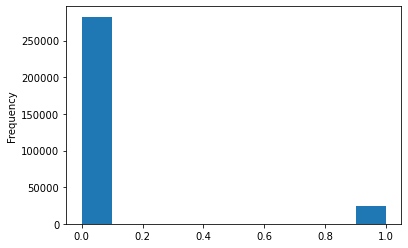

In [24]:
app_train['TARGET'].astype(int).plot.hist();

In [25]:
### Examine Missing Values

In [26]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [27]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [28]:
### Column Types

In [29]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [30]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [31]:
### Encoding Categorical Variables

In [32]:
# Create a label encoder object
# まとめてラベルエンコーディング
le = LabelEncoder()
le_count = 0

# Iterate through the columns
#for col in app_train:
#    if app_train[col].dtype == 'object':
#        # If 2 or fewer unique categories
#        if len(list(app_train[col].unique())) <= 2:
#            # Train on the training data
#            le.fit(app_train[col])
#            # Transform both training and testing data
#            app_train[col] = le.transform(app_train[col])
#            app_test[col] = le.transform(app_test[col])
#            
#            # Keep track of how many columns were label encoded
#            le_count += 1
            
#print('%d columns were label encoded.' % le_count)

In [33]:
# one-hot encoding of categorical variables
# まとめてone-hotエンコーディング
#app_train = pd.get_dummies(app_train)
#app_test = pd.get_dummies(app_test)

#print('Training Features shape: ', app_train.shape)
#print('Testing Features shape: ', app_test.shape)

### Correlations

In [34]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


### Effect of Age on Repayment

In [35]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

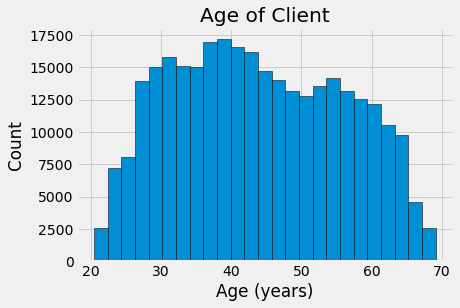

In [36]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

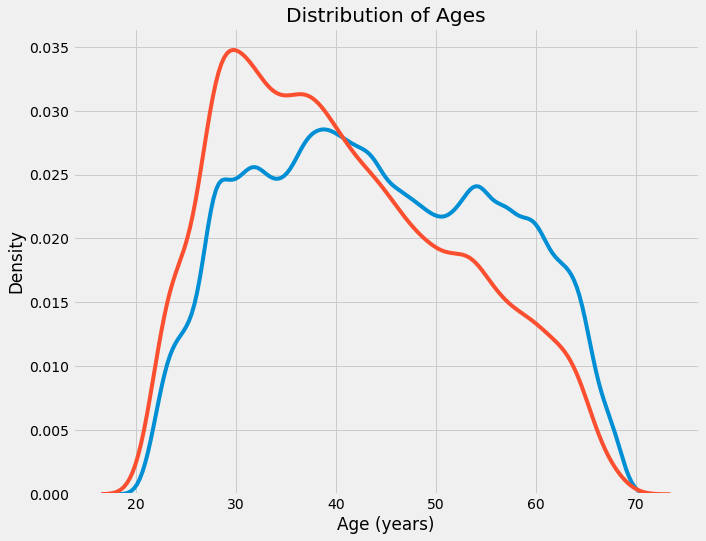

In [37]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [38]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [39]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

In [40]:
# Put test features into dataframe
#poly_features_test = pd.DataFrame(poly_features_test, 
#                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
#                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
#poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
#app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
#poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
#app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
#app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
#print('Training data with polynomial features shape: ', app_train_poly.shape)
#print('Testing data with polynomial features shape:  ', app_test_poly.shape)

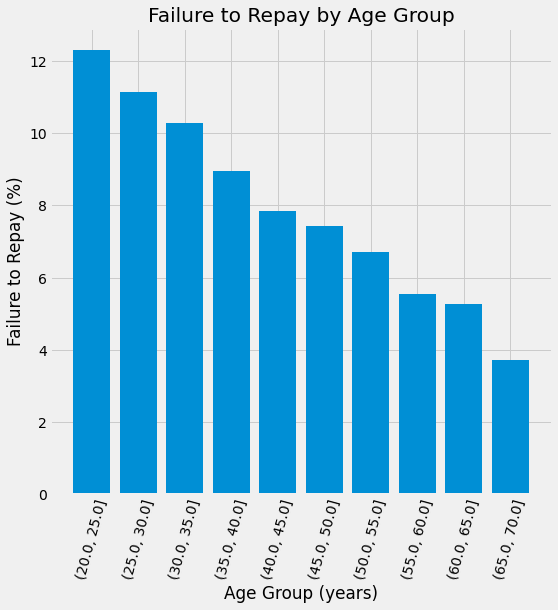

In [41]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Polynomial Features

In [42]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']].copy()
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()

# imputer for handling missing values
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [43]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [44]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [45]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [46]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].copy()
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

In [47]:
poly_features.head()

1  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1^2  \
0  1.0      0.083037      0.262949      0.139376      9461.0        0.006895   
1  1.0      0.311267      0.622246      0.535276     16765.0        0.096887   
2  1.0      0.505998      0.555912      0.729567     19046.0        0.256034   
3  1.0      0.505998      0.650442      0.535276     19005.0        0.256034   
4  1.0      0.505998      0.322738      0.535276     19932.0        0.256034   

   EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0                   0.021834                   0.011573   
1                   0.193685                   0.166614   
2                   0.281290                   0.369159   
3                   0.329122                   0.270849   
4                   0.163305                   0.270849   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2  ...  EXT_SOURCE_2^2 EXT_SOURCE_3  \
0               785.612748        0.069142  ...                     0.009637   
1              5218.396475        0.387190  ...                     0.207254   
2              9637.236584        0.309038  ...                     0.225464   
3              9616.490669        0.423074  ...                     0.226462   
4             10085.550751        0.104160  ...                     0.055754   

   EXT_SOURCE_2^2 DAYS_BIRTH  EXT_SOURCE_2 EXT_SOURCE_3^2  \
0                 654.152107                     0.005108   
1                6491.237078                     0.178286   
2                5885.942404                     0.295894   
3                8040.528832                     0.186365   
4                2076.117157                     0.092471   

   EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_2 DAYS_BIRTH^2  \
0                            346.733022               2.353667e+07   
1                           5583.975307               1.748916e+08   
2                           7724.580288               2.016572e+08   
3                           6616.894625               2.349331e+08   
4                           3443.335521               1.282190e+08   

   EXT_SOURCE_3^3  EXT_SOURCE_3^2 DAYS_BIRTH  EXT_SOURCE_3 DAYS_BIRTH^2  \
0        0.002707                 183.785678               1.247560e+07   
1        0.153368                4803.518937               1.504475e+08   
2        0.388325               10137.567875               2.646504e+08   
3        0.153368                5445.325225               1.933364e+08   
4        0.153368                5710.929881               2.126570e+08   

   DAYS_BIRTH^3  TARGET  
0  8.468590e+11       1  
1  4.712058e+12       0  
2  6.908939e+12       0  
3  6.864416e+12       0  
4  7.918677e+12       0  

[5 rows x 36 columns]

### Pairs Plot

In [48]:
# Copy the data for plotting
#plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
#plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
#plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
#def corr_func(x, y, **kwargs):
#    r = np.corrcoef(x, y)[0][1]
#    ax = plt.gca()
#    ax.annotate("r = {:.2f}".format(r),
#                xy=(.2, .8), xycoords=ax.transAxes,
#                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
#                    hue = 'TARGET', 
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

### Exterior Sources

In [49]:
plt.figure(figsize = (8, 6))

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

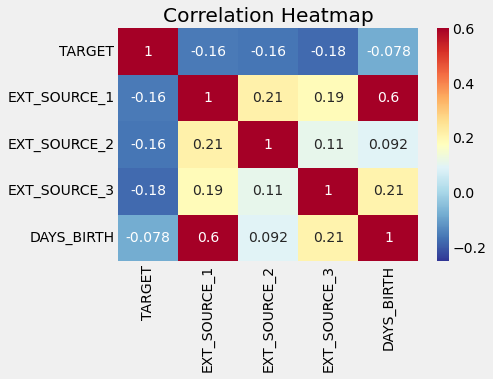

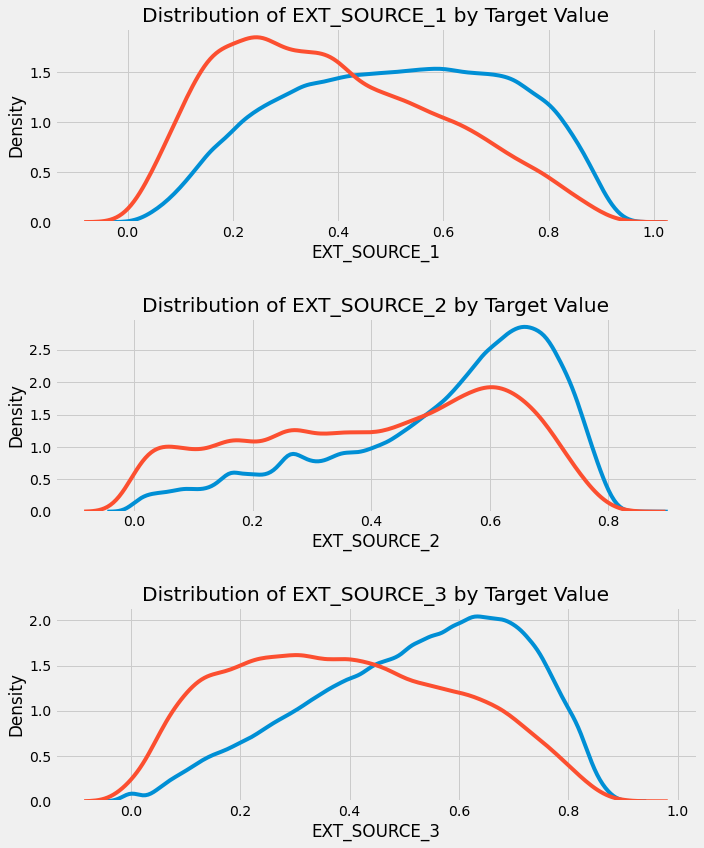

In [50]:
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Domain Knowledge Features

In [51]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [52]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

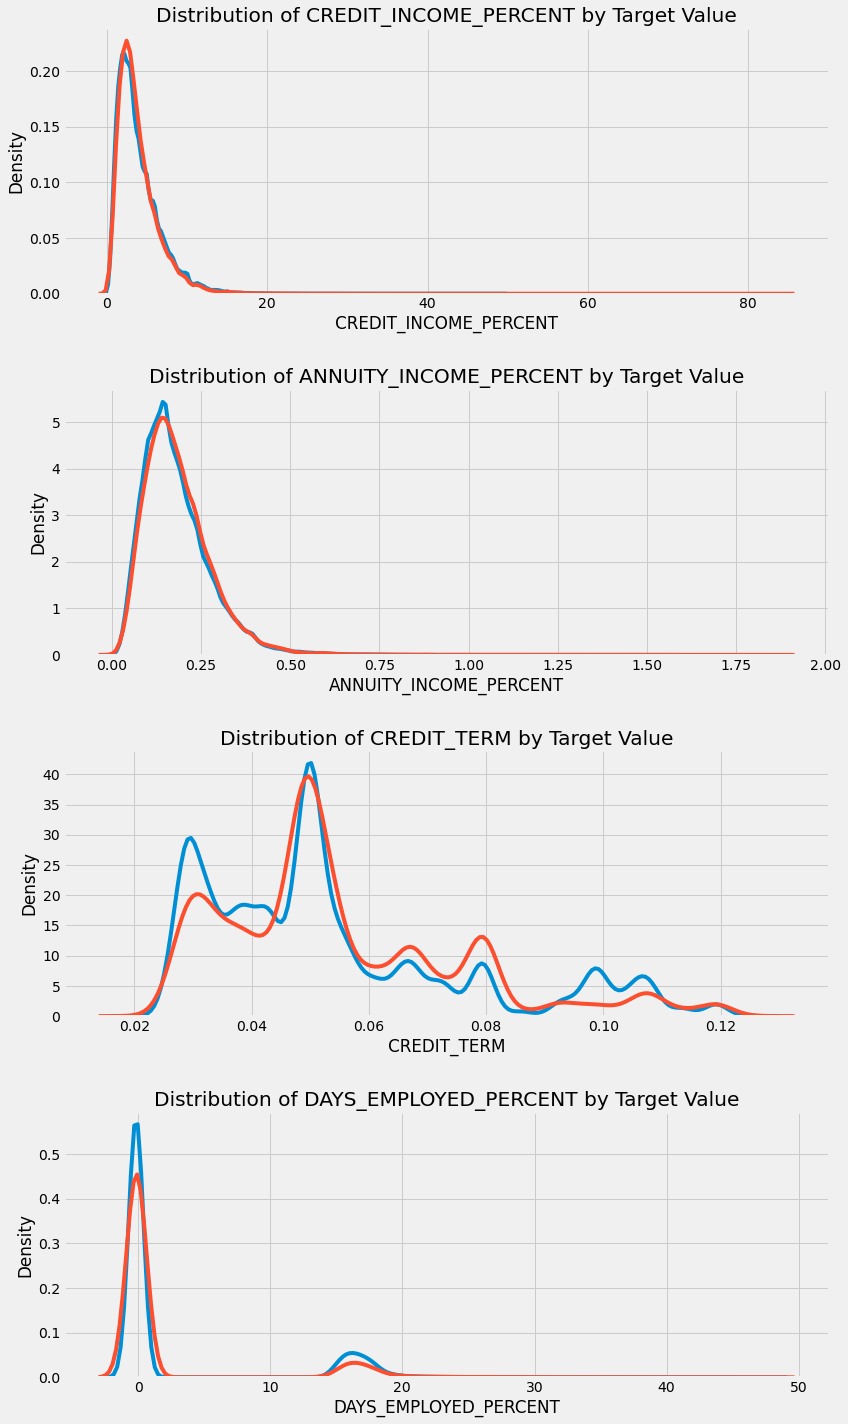

In [53]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [54]:
app_train['CREDIT_TERM'] = app_train_domain['CREDIT_TERM'].copy()
app_test['CREDIT_TERM'] = app_test_domain['CREDIT_TERM'].copy()

In [55]:
app_train[['CREDIT_TERM', 'TARGET']].corr()

CREDIT_TERM    TARGET
CREDIT_TERM     1.000000  0.012704
TARGET          0.012704  1.000000

In [56]:
app_train['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED_PERCENT'].copy()
app_test['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED_PERCENT'].copy()

In [57]:
app_train[['DAYS_EMPLOYED_PERCENT', 'TARGET']].corr()

DAYS_EMPLOYED_PERCENT    TARGET
DAYS_EMPLOYED_PERCENT               1.000000 -0.042206
TARGET                             -0.042206  1.000000

### 支払方法(現金/リボ)

In [58]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0  ...                 0                0                        0.0   
1  ...                 0                0                        0.0   
2  ...                 0                0                        0.0   
3  ...                 0                0                        NaN   
4  ...                 0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       NaN                        NaN   
4                       0.0                        0.0   

  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       NaN                        NaN   
4                       0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  
0                         1.0     0.060749              -0.067329  
1                         0.0     0.027598              -0.070862  
2                         0.0     0.050000              -0.011814  
3                         NaN     0.094941              -0.159905  
4                         0.0     0.042623              -0.152418  

[5 rows x 124 columns]

In [59]:
app_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [60]:
app_train['NAME_CONTRACT_TYPE'].isnull().sum()

0

In [61]:
app_train['NAME_CONTRACT_TYPE'].replace(['Cash loans', 'Revolving loans'], [0, 1], inplace=True)
app_test['NAME_CONTRACT_TYPE'].replace(['Cash loans', 'Revolving loans'], [0, 1], inplace=True)

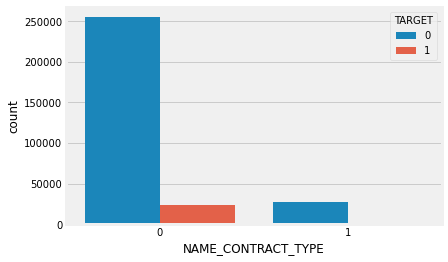

In [62]:
%matplotlib inline
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 性別

In [63]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [64]:
app_train['CODE_GENDER'].replace(['F', 'M', 'XNA'], [0, 1, 0], inplace=True)
app_test['CODE_GENDER'].replace(['F', 'M', 'XNA'], [0, 1, 0], inplace=True)
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER FLAG_OWN_CAR  \
0      100002       1                   0            1            N   
1      100003       0                   0            0            N   
2      100004       0                   1            1            Y   
3      100006       0                   0            0            N   
4      100007       0                   0            1            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0  ...                 0                0                        0.0   
1  ...                 0                0                        0.0   
2  ...                 0                0                        0.0   
3  ...                 0                0                        NaN   
4  ...                 0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       NaN                        NaN   
4                       0.0                        0.0   

  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       NaN                        NaN   
4                       0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  
0                         1.0     0.060749              -0.067329  
1                         0.0     0.027598              -0.070862  
2                         0.0     0.050000              -0.011814  
3                         NaN     0.094941              -0.159905  
4                         0.0     0.042623              -0.152418  

[5 rows x 124 columns]

In [65]:
app_train[['CODE_GENDER', 'TARGET']].corr()

CODE_GENDER    TARGET
CODE_GENDER     1.000000  0.054713
TARGET          0.054713  1.000000

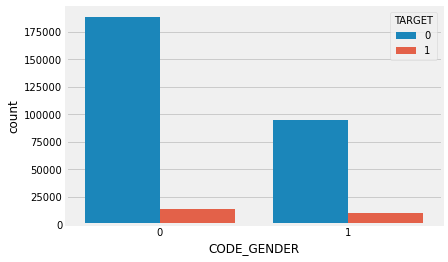

In [66]:
%matplotlib inline
sns.countplot(x='CODE_GENDER', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 車所有フラグ

In [67]:
app_train['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [68]:
app_train['FLAG_OWN_CAR'].replace(['Y', 'N'], [1, 0], inplace=True)
app_test['FLAG_OWN_CAR'].replace(['Y', 'N'], [1, 0], inplace=True)

In [69]:
app_train[['FLAG_OWN_CAR', 'TARGET']].corr()

FLAG_OWN_CAR    TARGET
FLAG_OWN_CAR      1.000000 -0.021851
TARGET           -0.021851  1.000000

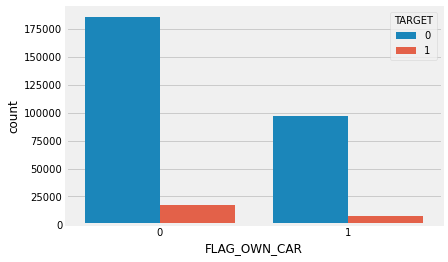

In [70]:
%matplotlib inline
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 不動産所有フラグ

In [71]:
app_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

In [72]:
app_train['FLAG_OWN_REALTY'].replace(['Y', 'N'], [1, 0], inplace=True)
app_test['FLAG_OWN_REALTY'].replace(['Y', 'N'], [1, 0], inplace=True)

In [73]:
app_train[['FLAG_OWN_REALTY', 'TARGET']].corr()

FLAG_OWN_REALTY    TARGET
FLAG_OWN_REALTY         1.000000 -0.006148
TARGET                 -0.006148  1.000000

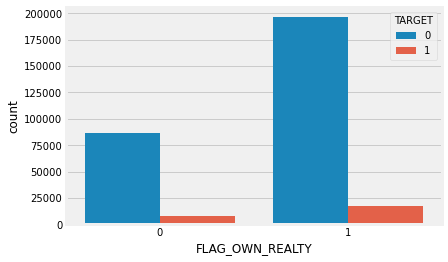

In [74]:
%matplotlib inline
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [75]:
app_train.drop(['FLAG_OWN_REALTY'], axis=1, inplace=True)
app_test.drop(['FLAG_OWN_REALTY'], axis=1, inplace=True)

### 雇用種別

In [76]:
app_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [77]:
app_train['OCCUPATION_TYPE'].replace(['Laborers','Sales staff','Core staff','Managers','Drivers','High skill tech staff','Accountants','Medicine staff','Security staff','Cooking staff','Cleaning staff','Private service staff','Low-skill Laborers','Waiters/barmen staff','Secretaries','Realty agents','HR staff','IT staff'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], inplace=True)
app_test['OCCUPATION_TYPE'].replace(['Laborers','Sales staff','Core staff','Managers','Drivers','High skill tech staff','Accountants','Medicine staff','Security staff','Cooking staff','Cleaning staff','Private service staff','Low-skill Laborers','Waiters/barmen staff','Secretaries','Realty agents','HR staff','IT staff'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18], inplace=True)

In [78]:
app_train['OCCUPATION_TYPE'].isnull().sum()

96391

In [79]:
app_train[['OCCUPATION_TYPE', 'TARGET']].corr()

OCCUPATION_TYPE    TARGET
OCCUPATION_TYPE         1.000000 -0.012412
TARGET                 -0.012412  1.000000

In [80]:
app_train['OCCUPATION_TYPE'].fillna(0, inplace=True)
app_test['OCCUPATION_TYPE'].fillna(0, inplace=True)

In [81]:
app_train['OCCUPATION_TYPE'].value_counts()

0.0     96391
1.0     55186
2.0     32102
3.0     27570
4.0     21371
5.0     18603
6.0     11380
7.0      9813
8.0      8537
9.0      6721
10.0     5946
11.0     4653
12.0     2652
13.0     2093
14.0     1348
15.0     1305
16.0      751
17.0      563
18.0      526
Name: OCCUPATION_TYPE, dtype: int64

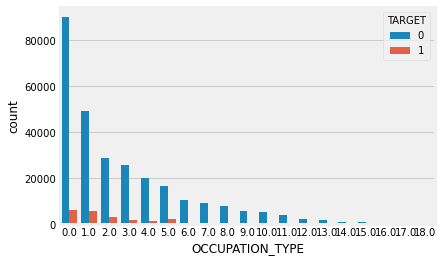

In [82]:
%matplotlib inline
sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [83]:
app_train[['OCCUPATION_TYPE','TARGET']].corr()

OCCUPATION_TYPE    TARGET
OCCUPATION_TYPE         1.000000  0.013045
TARGET                  0.013045  1.000000

In [84]:
#app_train.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)
#app_test.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)

### 家族ステータス

In [85]:
app_train['NAME_FAMILY_STATUS'].replace(['Married','Single / not married','Civil marriage','Separated','Widow','Unknown'], [0, 1, 2, 3, 4, 0], inplace=True)
app_test['NAME_FAMILY_STATUS'].replace(['Married','Single / not married','Civil marriage','Separated','Widow','Unknown'], [0, 1, 2, 3, 4, 0], inplace=True)

In [86]:
app_train['NAME_FAMILY_STATUS'].isnull().sum()

0

In [87]:
app_train['NAME_FAMILY_STATUS'].value_counts()

0    196434
1     45444
2     29775
3     19770
4     16088
Name: NAME_FAMILY_STATUS, dtype: int64

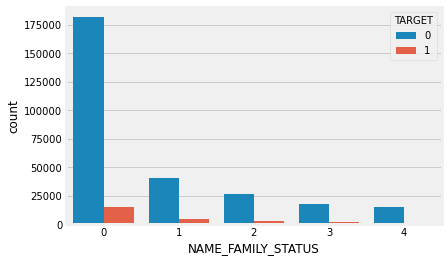

In [88]:
%matplotlib inline
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [89]:
app_train[['NAME_FAMILY_STATUS','TARGET']].corr()

NAME_FAMILY_STATUS   TARGET
NAME_FAMILY_STATUS             1.00000  0.00533
TARGET                         0.00533  1.00000

In [90]:
app_train.drop(['NAME_FAMILY_STATUS'], axis=1, inplace=True)
app_test.drop(['NAME_FAMILY_STATUS'], axis=1, inplace=True)

### 居住タイプ

In [91]:
app_train['NAME_HOUSING_TYPE'].replace(['House / apartment','With parents','Municipal apartment','Rented apartment','Office apartment','Co-op apartment'], [0, 1, 2, 3, 4, 5], inplace=True)
app_test['NAME_HOUSING_TYPE'].replace(['House / apartment','With parents','Municipal apartment','Rented apartment','Office apartment','Co-op apartment'], [0, 1, 2, 3, 4, 5], inplace=True)

In [92]:
app_train['NAME_HOUSING_TYPE'].value_counts()

0    272868
1     14840
2     11183
3      4881
4      2617
5      1122
Name: NAME_HOUSING_TYPE, dtype: int64

In [93]:
app_train['NAME_HOUSING_TYPE'].isnull().sum()

0

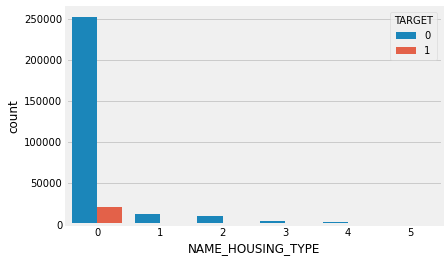

In [94]:
%matplotlib inline
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [95]:
app_train[['NAME_HOUSING_TYPE','TARGET']].corr()

NAME_HOUSING_TYPE    TARGET
NAME_HOUSING_TYPE           1.000000  0.018267
TARGET                      0.018267  1.000000

### NAME_INCOME_TYPE

In [96]:
app_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [97]:
app_train['NAME_INCOME_TYPE'].replace(['Working','Commercial associate','Pensioner','State servant','Unemployed','Student','Businessman','Maternity leave'], [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
app_test['NAME_INCOME_TYPE'].replace(['Working','Commercial associate','Pensioner','State servant','Unemployed','Student','Businessman','Maternity leave'], [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)

In [98]:
app_train['NAME_INCOME_TYPE'].value_counts()

0    158774
1     71617
2     55362
3     21703
4        22
5        18
6        10
7         5
Name: NAME_INCOME_TYPE, dtype: int64

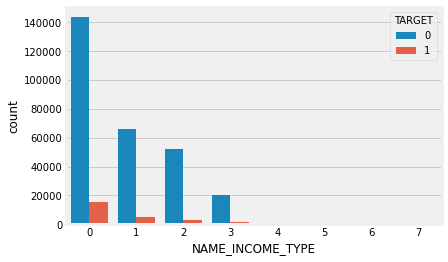

In [99]:
%matplotlib inline
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [100]:
app_train[['NAME_HOUSING_TYPE','TARGET']].corr()

NAME_HOUSING_TYPE    TARGET
NAME_HOUSING_TYPE           1.000000  0.018267
TARGET                      0.018267  1.000000

### 教育レベル

In [101]:
app_train['NAME_EDUCATION_TYPE'].isnull().sum()

0

In [102]:
app_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [103]:
app_train['NAME_EDUCATION_TYPE'].replace(['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree'], [0, 1, 2, 3, 4], inplace=True)
app_test['NAME_EDUCATION_TYPE'].replace(['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree'], [0, 1, 2, 3, 4], inplace=True)

In [104]:
app_train['NAME_EDUCATION_TYPE'].value_counts()

0    218391
1     74863
2     10277
3      3816
4       164
Name: NAME_EDUCATION_TYPE, dtype: int64

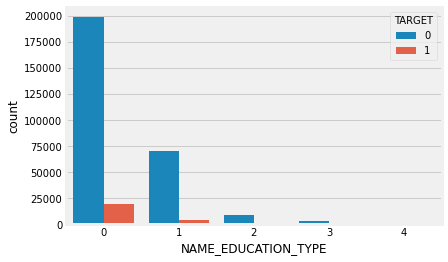

In [105]:
%matplotlib inline
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [106]:
app_train[['NAME_EDUCATION_TYPE','TARGET']].corr()

NAME_EDUCATION_TYPE    TARGET
NAME_EDUCATION_TYPE             1.000000 -0.032434
TARGET                         -0.032434  1.000000

### ローン対象の金額

In [107]:
app_train['AMT_GOODS_PRICE'].isnull().sum()

278

In [108]:
#app_train['AMT_GOODS_PRICE'].fillna(app_train['AMT_GOODS_PRICE'].median(), inplace=True)
#app_test['AMT_GOODS_PRICE'].fillna(app_train['AMT_GOODS_PRICE'].median(), inplace=True)

In [109]:
app_train['AMT_GOODS_PRICE'].min()

40500.0

In [110]:
app_train['AMT_GOODS_PRICE'].max()

4050000.0

In [111]:
## 目的変数との相関
app_train[['TARGET', 'AMT_GOODS_PRICE']].corr()

TARGET  AMT_GOODS_PRICE
TARGET           1.000000        -0.039645
AMT_GOODS_PRICE -0.039645         1.000000

The correlation between AMT_GOODS_PRICE and the TARGET is -0.0396
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     450000.0000


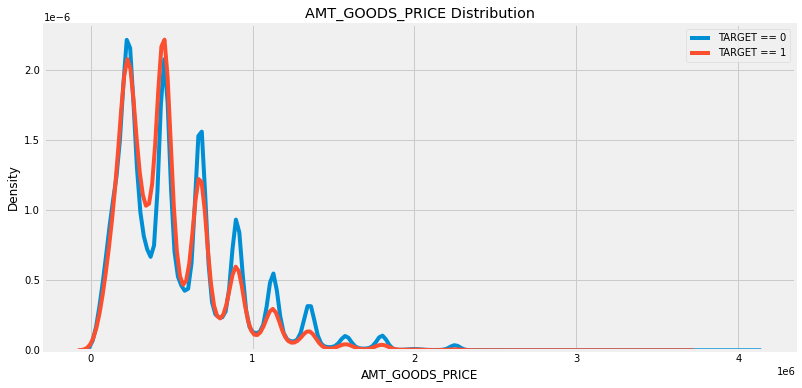

In [112]:
## 特徴量の分布
kde_target('AMT_GOODS_PRICE', app_train)

In [113]:
## Yao-Johnson変換
#num_cols = ['AMT_GOODS_PRICE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_GOODS_PRICE'] = pt.transform(app_train[num_cols])
#app_test['AMT_GOODS_PRICE'] = pt.transform(app_test[num_cols])

In [114]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_GOODS_PRICE']].corr()

In [115]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('AMT_GOODS_PRICE', app_train)

### NAME_TYPE_SUITE(ローン申請したときにクライアントに同行していた人)

In [116]:
app_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [117]:
replace_columns = app_train['NAME_TYPE_SUITE'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['NAME_TYPE_SUITE'].replace(replace_columns, replace_value, inplace=True)
app_test['NAME_TYPE_SUITE'].replace(replace_columns, replace_value, inplace=True)
app_train['NAME_TYPE_SUITE'].value_counts()

0.0    248526
1.0     40149
2.0     11370
3.0      3267
5.0      1770
4.0       866
6.0       271
Name: NAME_TYPE_SUITE, dtype: int64

In [118]:
app_train['NAME_TYPE_SUITE'].value_counts()

0.0    248526
1.0     40149
2.0     11370
3.0      3267
5.0      1770
4.0       866
6.0       271
Name: NAME_TYPE_SUITE, dtype: int64

In [119]:
app_train[['NAME_TYPE_SUITE', 'TARGET']].corr()

NAME_TYPE_SUITE    TARGET
NAME_TYPE_SUITE         1.000000 -0.002819
TARGET                 -0.002819  1.000000

In [120]:
app_train.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)
app_test.drop(['NAME_TYPE_SUITE'], axis=1, inplace=True)

### ローン支払額

In [121]:
app_train['AMT_ANNUITY'].isnull().sum()

12

In [122]:
#app_train['AMT_ANNUITY'].fillna(app_train['AMT_ANNUITY'].median(), inplace=True)
#app_test['AMT_ANNUITY'].fillna(app_train['AMT_ANNUITY'].median(), inplace=True)
#app_train['AMT_ANNUITY'].fillna(0, inplace=True)
#app_test['AMT_ANNUITY'].fillna(0, inplace=True)

In [123]:
## 目的変数との相関
app_train[['TARGET', 'AMT_ANNUITY']].corr()

TARGET  AMT_ANNUITY
TARGET       1.000000    -0.012817
AMT_ANNUITY -0.012817     1.000000

The correlation between AMT_ANNUITY and the TARGET is -0.0128
Median value for loan that was not repaid = 25263.0000
Median value for loan that was repaid =     24876.0000


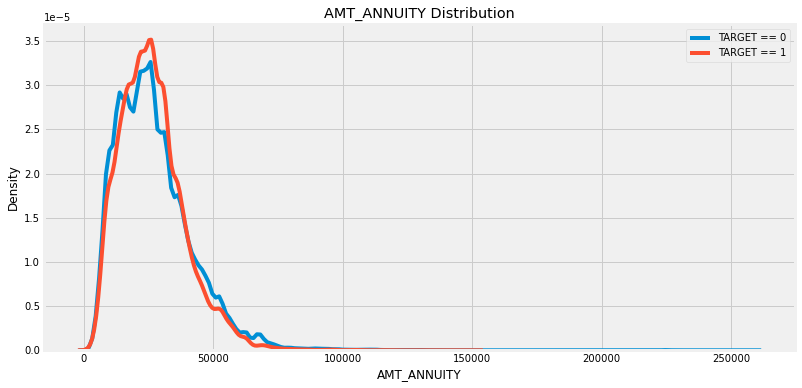

In [124]:
## 特徴量の分布
kde_target('AMT_ANNUITY', app_train)

In [125]:
## Yao-Johnson変換
#num_cols = ['AMT_ANNUITY']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['AMT_ANNUITY'] = pt.transform(app_train[num_cols])
#app_test['AMT_ANNUITY'] = pt.transform(app_test[num_cols])

In [126]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'AMT_ANNUITY']].corr()

In [127]:
app_train['credit_annuity_ratio'] = app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_test['credit_annuity_ratio'] = app_train['AMT_CREDIT']/app_test['AMT_ANNUITY']

In [128]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('AMT_ANNUITY', app_train)

### credit_annuity_ratio (AMT_CREDIT / AMT_ANNUITY)

In [129]:
max(app_train['credit_annuity_ratio'])

45.30507855316039

In [130]:
min(app_train['credit_annuity_ratio'])

8.036674497520229

In [131]:
#%matplotlib inline
#sns.countplot(x='credit_annuity_ratio', hue='TARGET', data=app_train)
#plt.legend(loc='upper right', title='TARGET')
#plt.show()

In [132]:
app_train[['credit_annuity_ratio','TARGET']].corr()

credit_annuity_ratio    TARGET
credit_annuity_ratio              1.000000 -0.032102
TARGET                           -0.032102  1.000000

### 家族の人数

In [133]:
app_train['CNT_FAM_MEMBERS'].isnull().sum()

2

In [134]:
app_train['CNT_FAM_MEMBERS'].min()

1.0

In [135]:
app_train['CNT_FAM_MEMBERS'].max()

20.0

In [136]:
app_train['CNT_FAM_MEMBERS'].fillna(app_train['CNT_FAM_MEMBERS'].median(), inplace=True)
app_test['CNT_FAM_MEMBERS'].fillna(app_train['CNT_FAM_MEMBERS'].median(), inplace=True)

In [137]:
app_train['CNT_FAM_MEMBERS'].value_counts()

2.0     158359
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

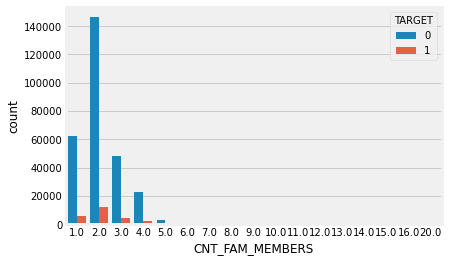

In [138]:
%matplotlib inline
sns.countplot(x='CNT_FAM_MEMBERS', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [139]:
app_train[['CNT_FAM_MEMBERS','TARGET']].corr()

CNT_FAM_MEMBERS    TARGET
CNT_FAM_MEMBERS         1.000000  0.009308
TARGET                  0.009308  1.000000

In [140]:
app_train.drop(['CNT_FAM_MEMBERS'], axis=1, inplace=True)
app_test.drop(['CNT_FAM_MEMBERS'], axis=1, inplace=True)

### 居住地域の人口

In [141]:
app_train['REGION_POPULATION_RELATIVE'].min()

0.00029

In [142]:
app_train['REGION_POPULATION_RELATIVE'].max()

0.072508

In [143]:
app_train['REGION_POPULATION_RELATIVE'].isnull().sum()

0

The correlation between REGION_POPULATION_RELATIVE and the TARGET is -0.0372
Median value for loan that was not repaid = 0.0186
Median value for loan that was repaid =     0.0188


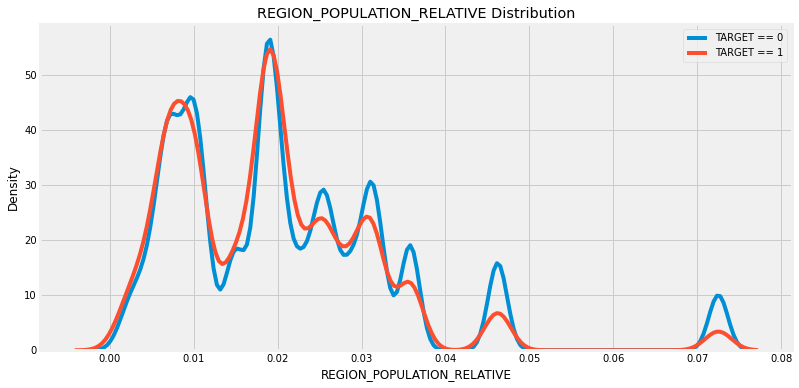

In [144]:
kde_target('REGION_POPULATION_RELATIVE', app_train)

In [145]:
#app_train['REGION_POPULATION_RELATIVE'] = pd.cut(app_train['REGION_POPULATION_RELATIVE'], bins=20, labels=False)
#app_test['REGION_POPULATION_RELATIVE'] =  pd.cut(app_test['REGION_POPULATION_RELATIVE'], bins=20, labels=False)

In [146]:
## Yao-Johnson変換
num_cols = ['REGION_POPULATION_RELATIVE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['REGION_POPULATION_RELATIVE'] = pt.transform(app_train[num_cols])
app_test['REGION_POPULATION_RELATIVE'] = pt.transform(app_test[num_cols])

In [147]:
#%matplotlib inline
#sns.countplot(x='REGION_POPULATION_RELATIVE', hue='TARGET', data=app_train)
#plt.legend(loc='upper right', title='TARGET')
#plt.show()

In [148]:
app_train[['REGION_POPULATION_RELATIVE', 'TARGET']].corr()

REGION_POPULATION_RELATIVE   TARGET
REGION_POPULATION_RELATIVE                     1.00000 -0.03157
TARGET                                        -0.03157  1.00000

The correlation between REGION_POPULATION_RELATIVE and the TARGET is -0.0316
Median value for loan that was not repaid = 0.0321
Median value for loan that was repaid =     0.0515


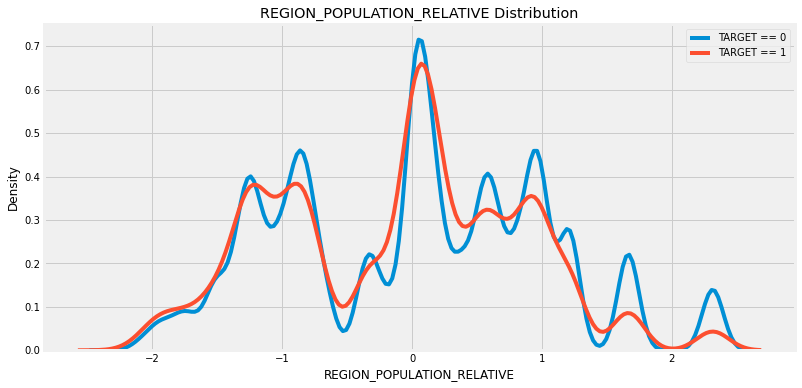

In [149]:
## Yao-Johnson変換後の特徴量の分布
kde_target('REGION_POPULATION_RELATIVE', app_train)

### DAYS_BIRTH

In [150]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

In [151]:
app_train[['DAYS_BIRTH', 'TARGET']].corr()

DAYS_BIRTH    TARGET
DAYS_BIRTH    1.000000 -0.078239
TARGET       -0.078239  1.000000

### DAYS_EMPLOYED

In [152]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

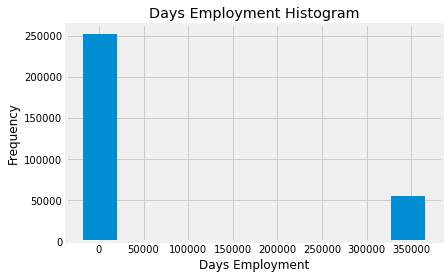

In [153]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [154]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


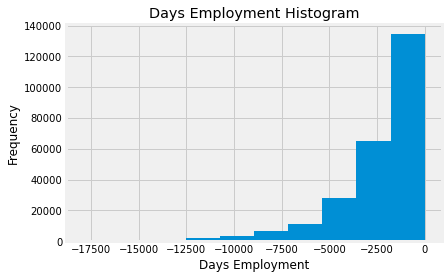

In [155]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [156]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


The correlation between DAYS_EMPLOYED and the TARGET is 0.0750
Median value for loan that was not repaid = -1230.0000
Median value for loan that was repaid =     -1691.0000


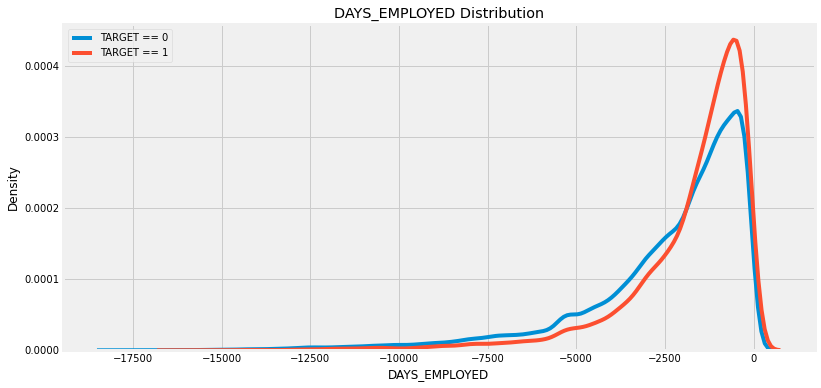

In [157]:
kde_target('DAYS_EMPLOYED', app_train)

In [158]:
app_train[['TARGET', 'DAYS_EMPLOYED']].corr()

TARGET  DAYS_EMPLOYED
TARGET         1.000000       0.074958
DAYS_EMPLOYED  0.074958       1.000000

### REGION_RATING_CLIENT

In [159]:
app_train['REGION_RATING_CLIENT'].isnull().sum()

0

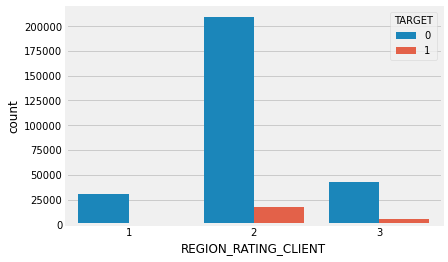

In [160]:
%matplotlib inline
sns.countplot(x='REGION_RATING_CLIENT', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

### 居住地域の正規化された人口

In [161]:
app_train[['REGION_RATING_CLIENT','TARGET']].corr()

REGION_RATING_CLIENT    TARGET
REGION_RATING_CLIENT              1.000000  0.058899
TARGET                            0.058899  1.000000

### WEEKDAY_APPR_PROCESS_START

In [162]:
app_train['WEEKDAY_APPR_PROCESS_START'].value_counts()

TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [163]:
replace_columns = app_train['WEEKDAY_APPR_PROCESS_START'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
#replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['WEEKDAY_APPR_PROCESS_START'].replace(replace_columns, replace_value, inplace=True)
app_test['WEEKDAY_APPR_PROCESS_START'].replace(replace_columns, replace_value, inplace=True)
app_train['WEEKDAY_APPR_PROCESS_START'].value_counts()

6    53901
0    51934
1    50714
2    50591
5    50338
4    33852
3    16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [164]:
app_train[['WEEKDAY_APPR_PROCESS_START', 'TARGET']].corr()

WEEKDAY_APPR_PROCESS_START    TARGET
WEEKDAY_APPR_PROCESS_START                    1.000000  0.003478
TARGET                                        0.003478  1.000000

In [165]:
columns = ['WEEKDAY_APPR_PROCESS_START']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### 居住地域のレーティング(市を考慮)

In [166]:
app_train['REGION_RATING_CLIENT_W_CITY'].isnull().sum()

0

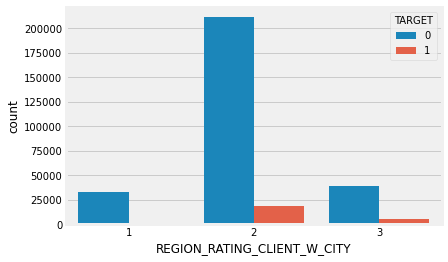

In [167]:
%matplotlib inline
sns.countplot(x='REGION_RATING_CLIENT_W_CITY', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [168]:
app_train[['REGION_RATING_CLIENT_W_CITY', 'TARGET']].corr()

REGION_RATING_CLIENT_W_CITY    TARGET
REGION_RATING_CLIENT_W_CITY                     1.000000  0.060893
TARGET                                          0.060893  1.000000

### credit_goods_price_ratio

In [169]:
app_train['credit_goods_price_ratio'] = app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']
app_test['credit_goods_price_ratio'] = app_test['AMT_CREDIT']/app_test['AMT_GOODS_PRICE']

In [170]:
#app_train['credit_goods_price_ratio'].fillna(0, inplace=True)
#app_test['credit_goods_price_ratio'].fillna(0, inplace=True)

In [171]:
app_train[['credit_goods_price_ratio', 'TARGET']].corr()

credit_goods_price_ratio    TARGET
credit_goods_price_ratio                  1.000000  0.069427
TARGET                                    0.069427  1.000000

### credit_downpayment 

In [172]:
app_train['credit_downpayment'] = app_train['AMT_GOODS_PRICE'] - app_train['AMT_CREDIT']
app_test['credit_downpayment'] = app_test['AMT_GOODS_PRICE'] - app_test['AMT_CREDIT']

In [173]:
#app_train['credit_downpayment'].fillna(0, inplace=True)
#app_test['credit_downpayment'].fillna(0, inplace=True)

In [174]:
app_train[['credit_downpayment', 'TARGET']].corr()

credit_downpayment    TARGET
credit_downpayment            1.000000 -0.034254
TARGET                       -0.034254  1.000000

### AGE_INT

In [175]:
app_train['AGE_INT'] = app_train['DAYS_BIRTH'] / -365
app_test['AGE_INT'] = app_test['DAYS_BIRTH'] / -365

In [176]:
app_train['AGE_INT'].astype('int')
app_test['AGE_INT'].astype('int')

0        52
1        49
2        54
3        38
4        35
         ..
48739    54
48740    30
48741    43
48742    38
48743    38
Name: AGE_INT, Length: 48744, dtype: int32

In [177]:
app_train[['AGE_INT', 'TARGET']].corr()

AGE_INT    TARGET
AGE_INT  1.000000  0.078239
TARGET   0.078239  1.000000

In [178]:
#app_train['AGE_INT'].fillna(0, inplace=True)
#app_test['AGE_INT'].fillna(0, inplace=True)

In [179]:
#%matplotlib inline
#sns.countplot(x='AGE_INT', hue='TARGET', data=app_train)
#plt.legend(loc='upper right', title='TARGET')
#plt.show()

### 外部ソース

<AxesSubplot:xlabel='EXT_SOURCE_1', ylabel='Count'>

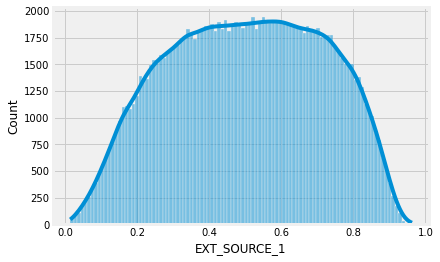

In [180]:
sns.histplot(
    app_train['EXT_SOURCE_1']
    ,kde = True
    ,bins = 100
)

In [181]:
min(app_train['EXT_SOURCE_1'])

0.0145681324124455

In [182]:
max(app_train['EXT_SOURCE_1'])

0.962692770561306

In [183]:
app_train[['EXT_SOURCE_1', 'TARGET']].corr()

EXT_SOURCE_1    TARGET
EXT_SOURCE_1      1.000000 -0.155317
TARGET           -0.155317  1.000000

In [184]:
#app_train['EXT_SOURCE_1'].fillna(0, inplace=True)
#app_test['EXT_SOURCE_1'].fillna(0, inplace=True)

#app_train['EXT_SOURCE_2'].fillna(0, inplace=True)
#app_test['EXT_SOURCE_2'].fillna(0, inplace=True)

#app_train['EXT_SOURCE_3'].fillna(0, inplace=True)
#app_test['EXT_SOURCE_3'].fillna(0, inplace=True)

### ORGANIZATION_TYPE

In [185]:
app_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [186]:
replace_columns = app_train['ORGANIZATION_TYPE'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
###replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['ORGANIZATION_TYPE'].replace(replace_columns, replace_value, inplace=True)
app_test['ORGANIZATION_TYPE'].replace(replace_columns, replace_value, inplace=True)
app_train['ORGANIZATION_TYPE'].value_counts()

0     67992
5     55374
9     38412
4     16683
7     11193
8     10553
2     10404
1      8893
14     7831
13     6880
11     6721
27     5984
19     5398
35     3492
38     3368
36     3278
22     3247
12     2958
15     2704
16     2634
37     2507
30     2454
26     2341
10     2204
28     2157
18     1974
23     1900
31     1811
17     1575
24     1327
34     1307
25     1187
20     1039
33      966
6       950
29      877
40      631
46      599
39      597
54      577
21      560
41      458
49      429
56      396
32      379
43      369
45      348
44      317
48      305
51      260
42      201
57      112
47      109
3        85
52       67
53       64
50       49
55       24
Name: ORGANIZATION_TYPE, dtype: int64

In [187]:
app_train[['ORGANIZATION_TYPE', 'TARGET']].corr()

ORGANIZATION_TYPE    TARGET
ORGANIZATION_TYPE           1.000000  0.004532
TARGET                      0.004532  1.000000

In [188]:
columns = ['ORGANIZATION_TYPE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_MOBIL

In [189]:
app_train['FLAG_MOBIL'].value_counts()

1    307510
0         1
Name: FLAG_MOBIL, dtype: int64

In [190]:
app_train[['FLAG_MOBIL', 'TARGET']].corr()

FLAG_MOBIL    TARGET
FLAG_MOBIL    1.000000  0.000534
TARGET        0.000534  1.000000

In [191]:
columns = ['FLAG_MOBIL']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_EMP_PHONE

In [192]:
app_train[['FLAG_EMP_PHONE', 'TARGET']].corr()

FLAG_EMP_PHONE    TARGET
FLAG_EMP_PHONE        1.000000  0.045982
TARGET                0.045982  1.000000

### FLAG_WORK_PHONE

In [193]:
app_train[['FLAG_WORK_PHONE', 'TARGET']].corr()

FLAG_WORK_PHONE    TARGET
FLAG_WORK_PHONE         1.000000  0.028524
TARGET                  0.028524  1.000000

### FLAG_CONT_MOBILE

In [194]:
app_train[['FLAG_CONT_MOBILE', 'TARGET']].corr()

FLAG_CONT_MOBILE   TARGET
FLAG_CONT_MOBILE           1.00000  0.00037
TARGET                     0.00037  1.00000

In [195]:
columns = ['FLAG_CONT_MOBILE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_PHONE

In [196]:
app_train[['FLAG_PHONE', 'TARGET']].corr()

FLAG_PHONE    TARGET
FLAG_PHONE    1.000000 -0.023806
TARGET       -0.023806  1.000000

### FLAG_EMAIL

In [197]:
app_train[['FLAG_EMAIL', 'TARGET']].corr()

FLAG_EMAIL    TARGET
FLAG_EMAIL    1.000000 -0.001758
TARGET       -0.001758  1.000000

In [198]:
columns = ['FLAG_EMAIL']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### APARTMENTS_AVG

In [199]:
app_train[['APARTMENTS_AVG', 'TARGET']].value_counts()

APARTMENTS_AVG  TARGET
0.0825          0         6192
0.0619          0         5934
0.0928          0         4100
0.0722          0         3687
0.0082          0         3182
                          ... 
0.2606          0            1
0.0294          1            1
0.0908          1            1
0.2624          1            1
0.0750          0            1
Length: 3272, dtype: int64

In [200]:
## 目的変数との相関
app_train[['TARGET', 'APARTMENTS_AVG']].corr()

TARGET  APARTMENTS_AVG
TARGET          1.000000       -0.029498
APARTMENTS_AVG -0.029498        1.000000

The correlation between APARTMENTS_AVG and the TARGET is -0.0295
Median value for loan that was not repaid = 0.0825
Median value for loan that was repaid =     0.0887


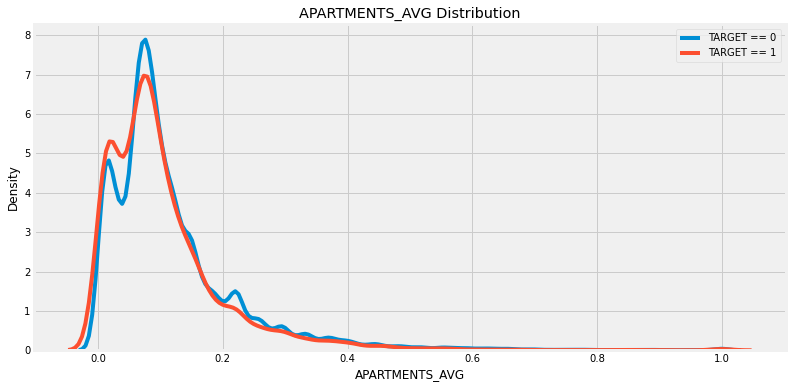

In [201]:
## 特徴量の分布
kde_target('APARTMENTS_AVG', app_train)

In [202]:
## Yao-Johnson変換
num_cols = ['APARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['APARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['APARTMENTS_AVG'] = pt.transform(app_test[num_cols])

In [203]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'APARTMENTS_AVG']].corr()

TARGET  APARTMENTS_AVG
TARGET          1.000000       -0.036482
APARTMENTS_AVG -0.036482        1.000000

The correlation between APARTMENTS_AVG and the TARGET is -0.0365
Median value for loan that was not repaid = -0.1505
Median value for loan that was repaid =     -0.0545


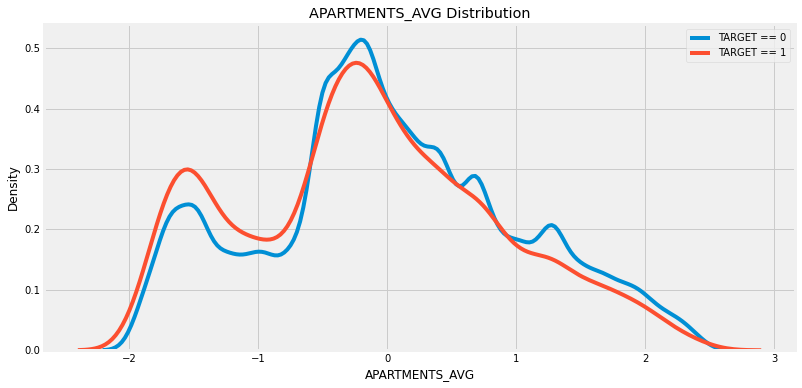

In [204]:
## Yao-Johnson変換後の特徴量の分布
kde_target('APARTMENTS_AVG', app_train)

### BASEMENTAREA_AVG

In [205]:
app_train['BASEMENTAREA_AVG'].value_counts()

0.0000    14745
0.0545      251
0.0818      251
0.0727      248
0.1091      246
          ...  
0.2999        1
0.2737        1
0.4696        1
0.2992        1
0.6360        1
Name: BASEMENTAREA_AVG, Length: 3780, dtype: int64

In [206]:
## 目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_AVG']].corr()

TARGET  BASEMENTAREA_AVG
TARGET            1.000000         -0.022746
BASEMENTAREA_AVG -0.022746          1.000000

In [207]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_AVG'] = pt.transform(app_test[num_cols])

In [208]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_AVG']].corr()

TARGET  BASEMENTAREA_AVG
TARGET            1.000000         -0.023919
BASEMENTAREA_AVG -0.023919          1.000000

The correlation between BASEMENTAREA_AVG and the TARGET is -0.0239
Median value for loan that was not repaid = -0.0125
Median value for loan that was repaid =     0.0619


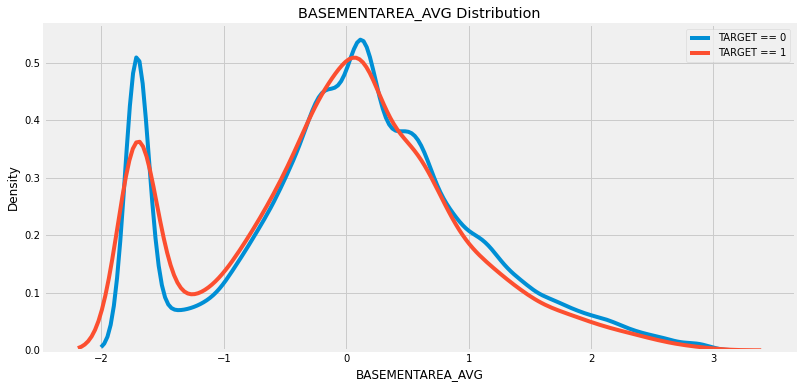

In [209]:
## Yao-Johnson変換後の特徴量の分布
kde_target('BASEMENTAREA_AVG', app_train)

### YEARS_BEGINEXPLUATATION_AVG

In [210]:
app_train['YEARS_BEGINEXPLUATATION_AVG'].value_counts()

0.9871    4311
0.9856    4189
0.9861    4171
0.9801    4123
0.9866    4114
          ... 
0.8992       1
0.8276       1
0.3279       1
0.6577       1
0.8629       1
Name: YEARS_BEGINEXPLUATATION_AVG, Length: 285, dtype: int64

In [211]:
app_train[['YEARS_BEGINEXPLUATATION_AVG', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_AVG    TARGET
YEARS_BEGINEXPLUATATION_AVG                     1.000000 -0.009728
TARGET                                         -0.009728  1.000000

The correlation between YEARS_BEGINEXPLUATATION_AVG and the TARGET is -0.0097
Median value for loan that was not repaid = 0.9811
Median value for loan that was repaid =     0.9821


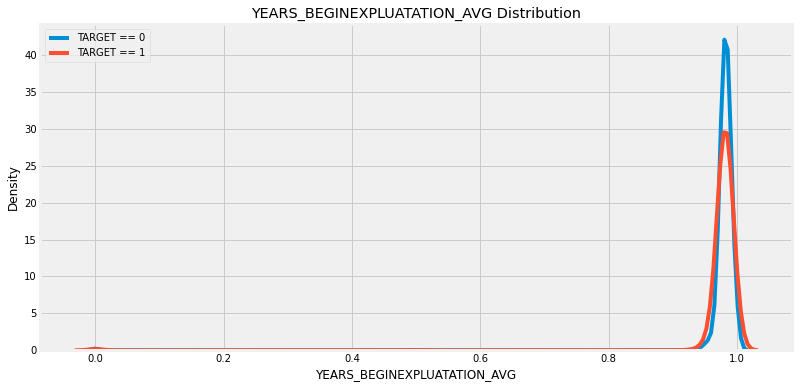

In [212]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_AVG', app_train)

In [213]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_AVG'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_AVG'] = pt.transform(app_test[num_cols])

In [214]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_AVG']].corr()

TARGET  YEARS_BEGINEXPLUATATION_AVG
TARGET                       1.00000                     -0.02748
YEARS_BEGINEXPLUATATION_AVG -0.02748                      1.00000

The correlation between YEARS_BEGINEXPLUATATION_AVG and the TARGET is -0.0275
Median value for loan that was not repaid = -0.1137
Median value for loan that was repaid =     0.0014


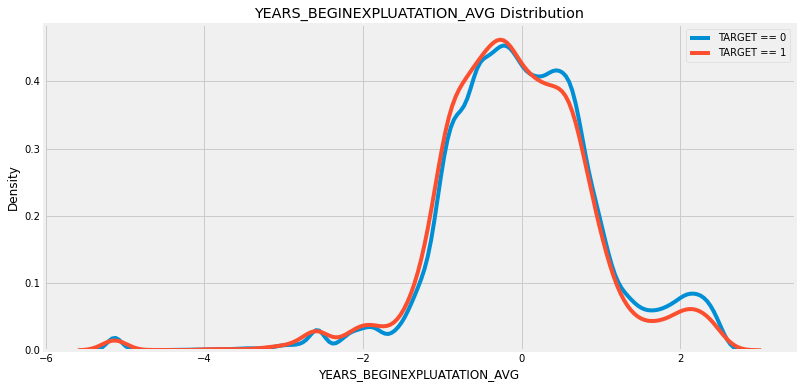

In [215]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_AVG', app_train)

In [216]:
#columns = ['YEARS_BEGINEXPLUATATION_AVG']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### YEARS_BUILD_AVG

In [217]:
app_train['YEARS_BUILD_AVG'].value_counts()

0.8232    2999
0.8164    2864
0.8028    2848
0.7280    2802
0.7348    2761
          ... 
0.1976       2
0.3744       2
0.0004       2
0.0276       1
0.0208       1
Name: YEARS_BUILD_AVG, Length: 149, dtype: int64

In [218]:
## 目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_AVG']].corr()

TARGET  YEARS_BUILD_AVG
TARGET           1.000000        -0.022149
YEARS_BUILD_AVG -0.022149         1.000000

The correlation between YEARS_BUILD_AVG and the TARGET is -0.0221
Median value for loan that was not repaid = 0.7484
Median value for loan that was repaid =     0.7552


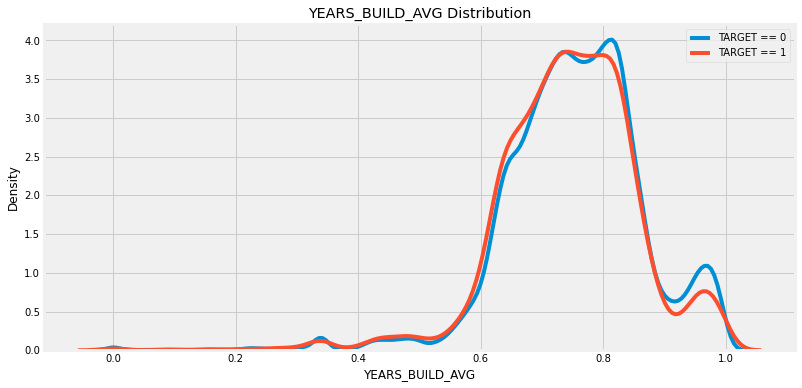

In [219]:
## 特徴量の分布
kde_target('YEARS_BUILD_AVG', app_train)

In [220]:
## Yao-Johnson変換
num_cols = ['YEARS_BUILD_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BUILD_AVG'] = pt.transform(app_train[num_cols])
app_test['YEARS_BUILD_AVG'] = pt.transform(app_test[num_cols])

In [221]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_AVG']].corr()

TARGET  YEARS_BUILD_AVG
TARGET           1.000000        -0.023555
YEARS_BUILD_AVG -0.023555         1.000000

The correlation between YEARS_BUILD_AVG and the TARGET is -0.0236
Median value for loan that was not repaid = -0.1210
Median value for loan that was repaid =     -0.0583


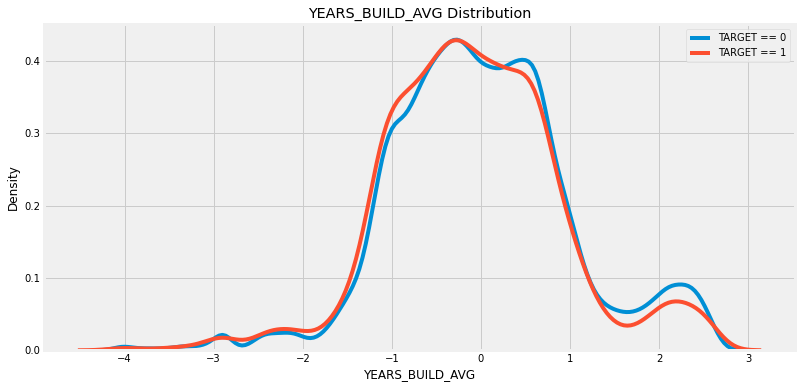

In [222]:
kde_target('YEARS_BUILD_AVG', app_train)

### COMMONAREA_AVG

In [223]:
app_train['COMMONAREA_AVG'].value_counts()

0.0000    8442
0.0079     544
0.0078     475
0.0080     446
0.0077     414
          ... 
0.2299       1
0.2496       1
0.2737       1
0.3814       1
0.1620       1
Name: COMMONAREA_AVG, Length: 3181, dtype: int64

In [224]:
app_train[['COMMONAREA_AVG', 'TARGET']].corr()

COMMONAREA_AVG   TARGET
COMMONAREA_AVG         1.00000 -0.01855
TARGET                -0.01855  1.00000

The correlation between COMMONAREA_AVG and the TARGET is -0.0185
Median value for loan that was not repaid = 0.0186
Median value for loan that was repaid =     0.0213


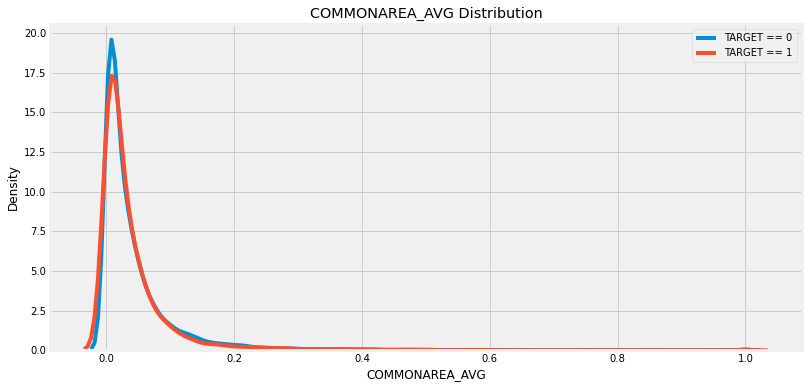

In [225]:
## 特徴量の分布
kde_target('COMMONAREA_AVG', app_train)

In [226]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_AVG'] = pt.transform(app_test[num_cols])

In [227]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_AVG']].corr()

TARGET  COMMONAREA_AVG
TARGET          1.000000       -0.020448
COMMONAREA_AVG -0.020448        1.000000

The correlation between COMMONAREA_AVG and the TARGET is -0.0204
Median value for loan that was not repaid = -0.3187
Median value for loan that was repaid =     -0.2057


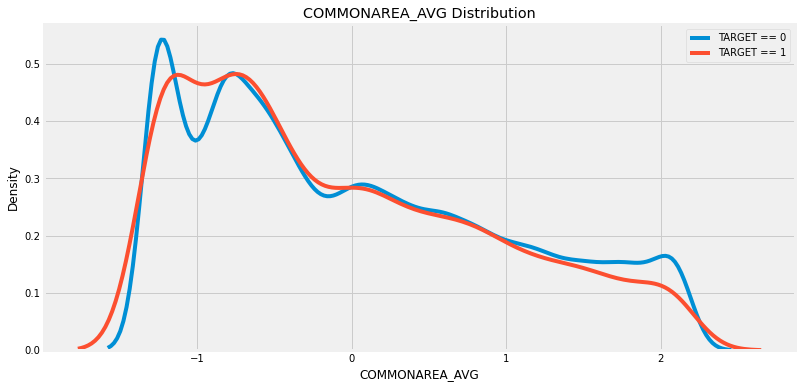

In [228]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_AVG', app_train)

### ELEVATORS_AVG

In [229]:
app_train['ELEVATORS_AVG'].value_counts()

0.0000    85718
0.0800     9886
0.1600     8806
0.2400     6071
0.1200     5593
          ...  
0.2284        1
0.0828        1
0.0232        1
0.0180        1
0.0528        1
Name: ELEVATORS_AVG, Length: 257, dtype: int64

In [230]:
app_train[['ELEVATORS_AVG', 'TARGET']].corr()

ELEVATORS_AVG    TARGET
ELEVATORS_AVG       1.000000 -0.034199
TARGET             -0.034199  1.000000

The correlation between ELEVATORS_AVG and the TARGET is -0.0342
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


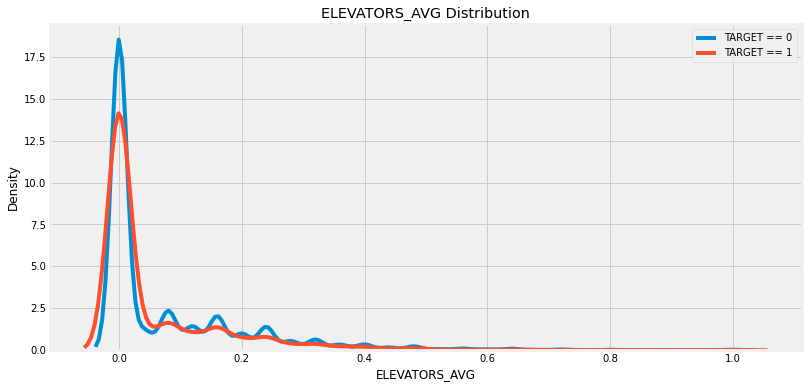

In [231]:
## 特徴量の分布
kde_target('ELEVATORS_AVG', app_train)

In [232]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_AVG'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_AVG'] = pt.transform(app_test[num_cols])

In [233]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_AVG']].corr()

TARGET  ELEVATORS_AVG
TARGET         1.000000      -0.038592
ELEVATORS_AVG -0.038592       1.000000

The correlation between ELEVATORS_AVG and the TARGET is -0.0386
Median value for loan that was not repaid = -0.7711
Median value for loan that was repaid =     -0.7711


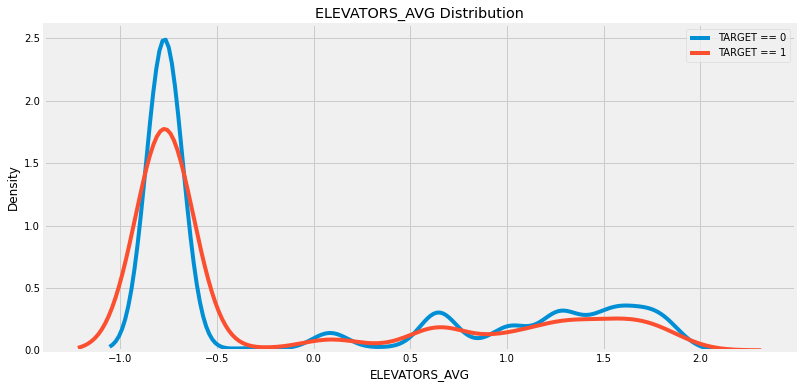

In [234]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_AVG', app_train)

### ENTRANCES_AVG

In [235]:
app_train['ENTRANCES_AVG'].value_counts()

0.1379    34007
0.0690    22956
0.1034    19533
0.2069    19062
0.0345    15380
          ...  
0.0355        1
0.1645        1
0.2145        1
0.1341        1
0.1059        1
Name: ENTRANCES_AVG, Length: 285, dtype: int64

In [236]:
app_train[['ENTRANCES_AVG', 'TARGET']].corr()

ENTRANCES_AVG    TARGET
ENTRANCES_AVG       1.000000 -0.019172
TARGET             -0.019172  1.000000

In [237]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_AVG'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_AVG'] = pt.transform(app_test[num_cols])

In [238]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_AVG']].corr()

TARGET  ENTRANCES_AVG
TARGET         1.000000      -0.023521
ENTRANCES_AVG -0.023521       1.000000

The correlation between ENTRANCES_AVG and the TARGET is -0.0235
Median value for loan that was not repaid = 0.1029
Median value for loan that was repaid =     0.1029


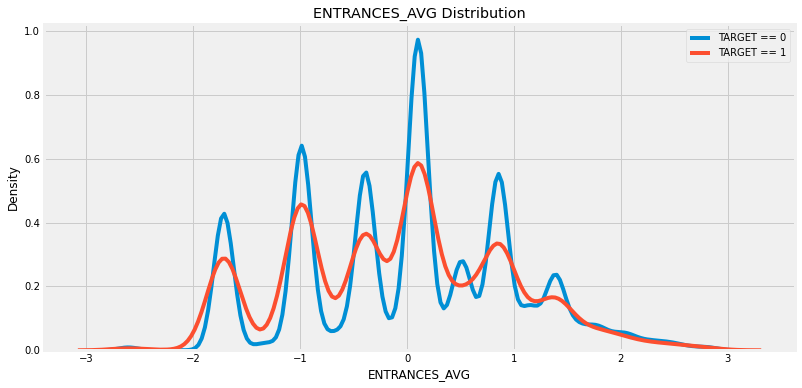

In [239]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_AVG', app_train)

### FLOORSMAX_AVG

In [240]:
app_train['FLOORSMAX_AVG'].value_counts()

0.1667    61875
0.3333    31909
0.0417    14600
0.3750     7926
0.1250     6974
          ...  
0.1792        1
0.2200        1
0.1133        1
0.0900        1
0.2042        1
Name: FLOORSMAX_AVG, Length: 403, dtype: int64

In [241]:
app_train[['FLOORSMAX_AVG', 'TARGET']].corr()

FLOORSMAX_AVG    TARGET
FLOORSMAX_AVG       1.000000 -0.044003
TARGET             -0.044003  1.000000

The correlation between FLOORSMAX_AVG and the TARGET is -0.0440
Median value for loan that was not repaid = 0.1667
Median value for loan that was repaid =     0.1667


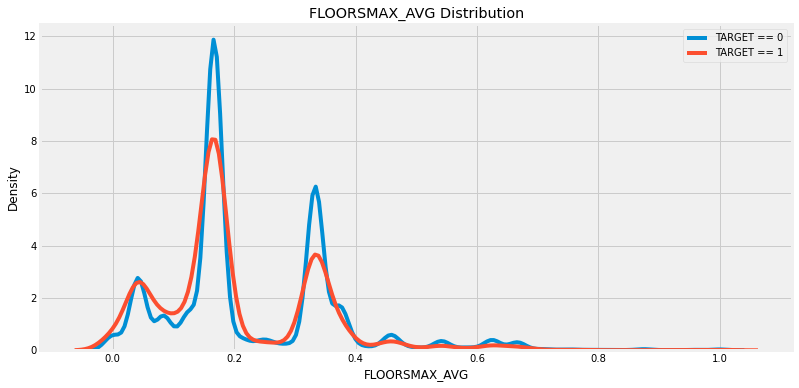

In [242]:
## 特徴量の分布
kde_target('FLOORSMAX_AVG', app_train)

In [243]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_AVG'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_AVG'] = pt.transform(app_test[num_cols])

In [244]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_AVG']].corr()

TARGET  FLOORSMAX_AVG
TARGET         1.000000      -0.046355
FLOORSMAX_AVG -0.046355       1.000000

The correlation between FLOORSMAX_AVG and the TARGET is -0.0464
Median value for loan that was not repaid = -0.2925
Median value for loan that was repaid =     -0.2925


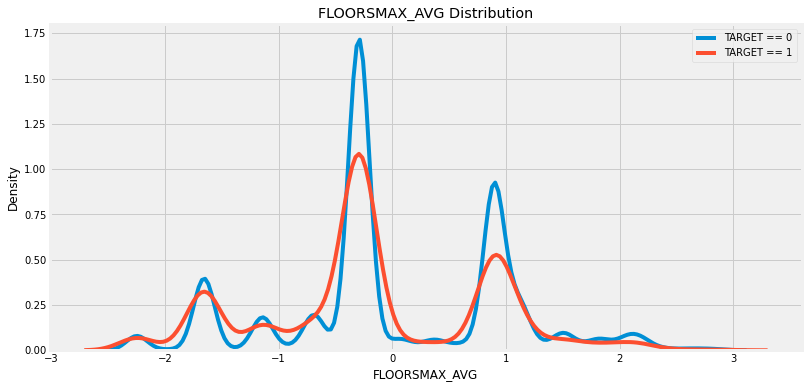

In [245]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_AVG', app_train)

### LANDAREA_AVG

In [246]:
app_train['LANDAREA_AVG'].value_counts()

0.0000    15600
0.0631      189
0.0316      187
0.0473      186
0.0174      180
          ...  
0.2617        1
0.2539        1
0.2416        1
0.3417        1
0.3130        1
Name: LANDAREA_AVG, Length: 3527, dtype: int64

In [247]:
app_train[['LANDAREA_AVG', 'TARGET']].corr()

LANDAREA_AVG    TARGET
LANDAREA_AVG      1.000000 -0.010885
TARGET           -0.010885  1.000000

The correlation between LANDAREA_AVG and the TARGET is -0.0109
Median value for loan that was not repaid = 0.0449
Median value for loan that was repaid =     0.0484


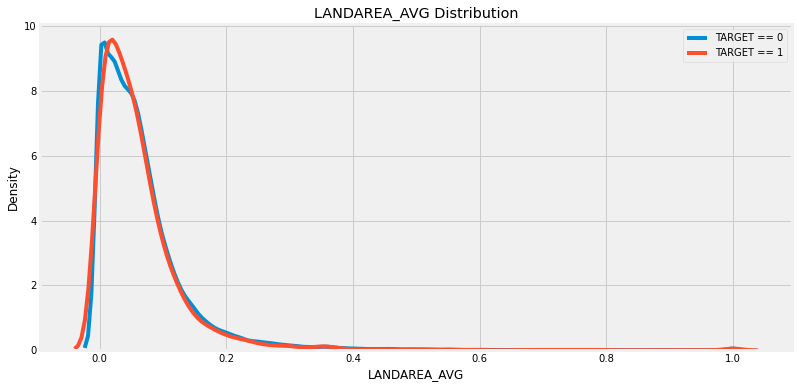

In [248]:
## 特徴量の分布
kde_target('LANDAREA_AVG', app_train)

In [249]:
## Yao-Johnson変換
num_cols = ['LANDAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_AVG'] = pt.transform(app_test[num_cols])

In [250]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_AVG']].corr()

TARGET  LANDAREA_AVG
TARGET        1.000000     -0.013737
LANDAREA_AVG -0.013737      1.000000

The correlation between LANDAREA_AVG and the TARGET is -0.0137
Median value for loan that was not repaid = -0.0847
Median value for loan that was repaid =     -0.0018


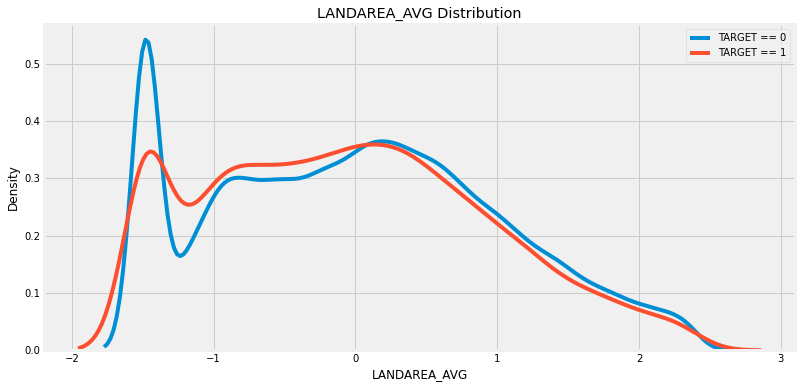

In [251]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_AVG', app_train)

### LIVINGAPARTMENTS_AVG

In [252]:
app_train['LIVINGAPARTMENTS_AVG'].value_counts()

0.0504    4272
0.0672    4231
0.0756    2778
0.0588    2586
0.0841    1864
          ... 
0.7128       1
0.1401       1
0.5085       1
0.1575       1
0.1543       1
Name: LIVINGAPARTMENTS_AVG, Length: 1868, dtype: int64

In [253]:
app_train[['LIVINGAPARTMENTS_AVG', 'TARGET']].corr()

LIVINGAPARTMENTS_AVG    TARGET
LIVINGAPARTMENTS_AVG              1.000000 -0.025031
TARGET                           -0.025031  1.000000

The correlation between LIVINGAPARTMENTS_AVG and the TARGET is -0.0250
Median value for loan that was not repaid = 0.0672
Median value for loan that was repaid =     0.0756


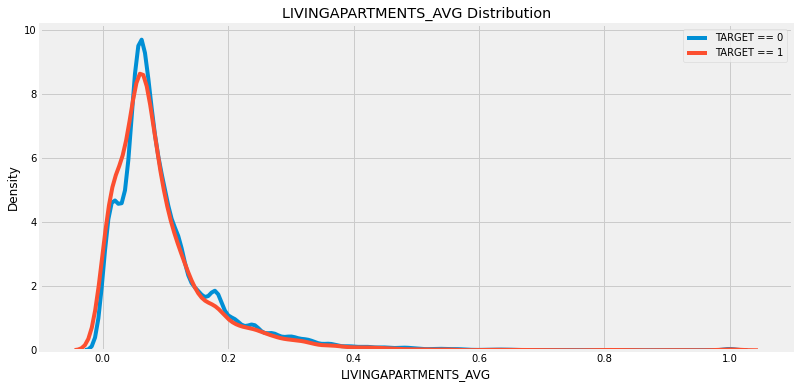

In [254]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_AVG', app_train)

In [255]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_AVG'] = pt.transform(app_test[num_cols])

In [256]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_AVG']].corr()

TARGET  LIVINGAPARTMENTS_AVG
TARGET                1.000000             -0.031872
LIVINGAPARTMENTS_AVG -0.031872              1.000000

The correlation between LIVINGAPARTMENTS_AVG and the TARGET is -0.0319
Median value for loan that was not repaid = -0.2316
Median value for loan that was repaid =     -0.0698


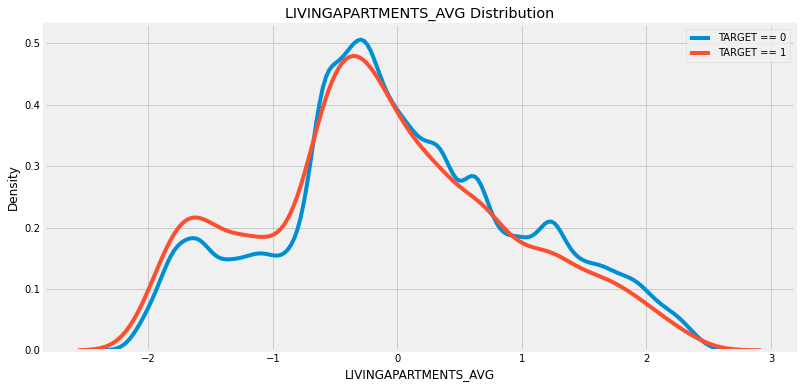

In [257]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_AVG', app_train)

### LIVINGAREA_AVG

In [258]:
app_train['LIVINGAREA_AVG'].value_counts()

0.0000    284
0.0512    243
0.0510    223
0.0702    223
0.0509    221
         ... 
0.3750      1
0.5441      1
0.4038      1
0.3755      1
0.9279      1
Name: LIVINGAREA_AVG, Length: 5199, dtype: int64

In [259]:
app_train[['LIVINGAREA_AVG', 'TARGET']].corr()

LIVINGAREA_AVG    TARGET
LIVINGAREA_AVG        1.000000 -0.032997
TARGET               -0.032997  1.000000

The correlation between LIVINGAREA_AVG and the TARGET is -0.0330
Median value for loan that was not repaid = 0.0667
Median value for loan that was repaid =     0.0752


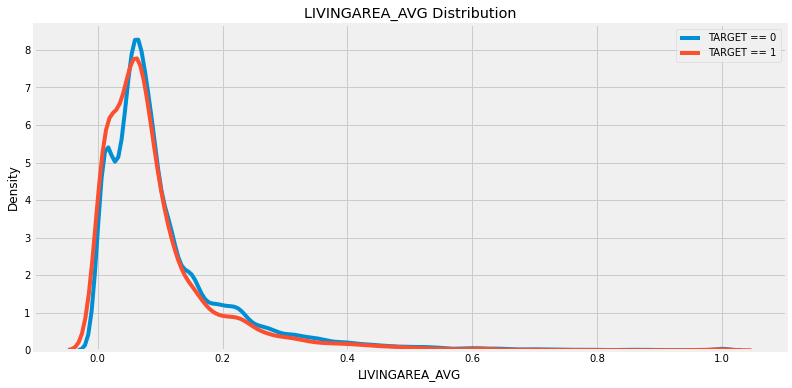

In [260]:
## 特徴量の分布
kde_target('LIVINGAREA_AVG', app_train)

In [261]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_AVG'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_AVG'] = pt.transform(app_test[num_cols])

In [262]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_AVG']].corr()

TARGET  LIVINGAREA_AVG
TARGET          1.00000        -0.04192
LIVINGAREA_AVG -0.04192         1.00000

The correlation between LIVINGAREA_AVG and the TARGET is -0.0419
Median value for loan that was not repaid = -0.2268
Median value for loan that was repaid =     -0.0778


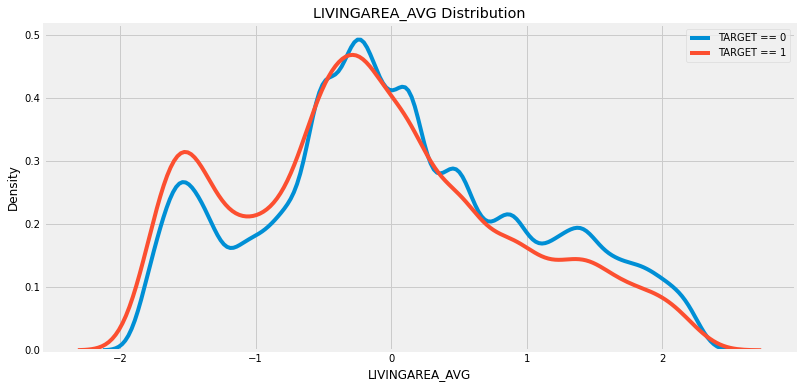

In [263]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_AVG', app_train)

### NONLIVINGAPARTMENTS_AVG

In [264]:
app_train['NONLIVINGAPARTMENTS_AVG'].value_counts()

0.0000    54549
0.0039    13606
0.0077     6351
0.0116     3714
0.0154     2533
          ...  
0.2664        1
0.0323        1
0.0946        1
0.0091        1
0.0319        1
Name: NONLIVINGAPARTMENTS_AVG, Length: 386, dtype: int64

In [265]:
app_train[['NONLIVINGAPARTMENTS_AVG', 'TARGET']].corr()

NONLIVINGAPARTMENTS_AVG    TARGET
NONLIVINGAPARTMENTS_AVG                 1.000000 -0.003176
TARGET                                 -0.003176  1.000000

The correlation between NONLIVINGAPARTMENTS_AVG and the TARGET is -0.0032
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


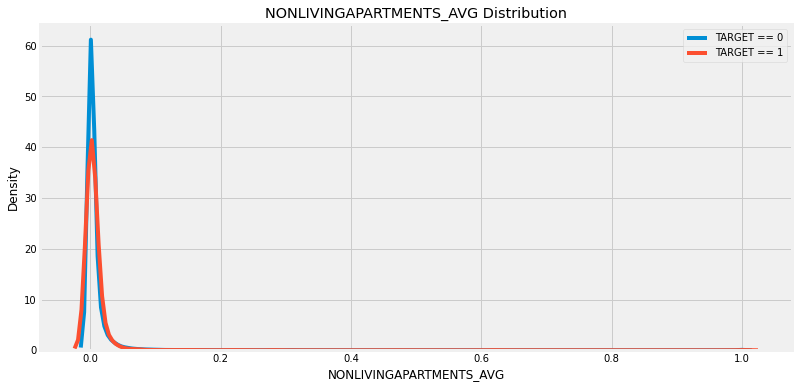

In [266]:
## 特徴量の分布
kde_target('NONLIVINGAPARTMENTS_AVG', app_train)

In [267]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_AVG']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_AVG'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_AVG'] = pt.transform(app_test[num_cols])

In [268]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_AVG']].corr()

TARGET  NONLIVINGAPARTMENTS_AVG
TARGET                   1.000000                -0.007975
NONLIVINGAPARTMENTS_AVG -0.007975                 1.000000

The correlation between NONLIVINGAPARTMENTS_AVG and the TARGET is -0.0080
Median value for loan that was not repaid = -0.7040
Median value for loan that was repaid =     -0.7040


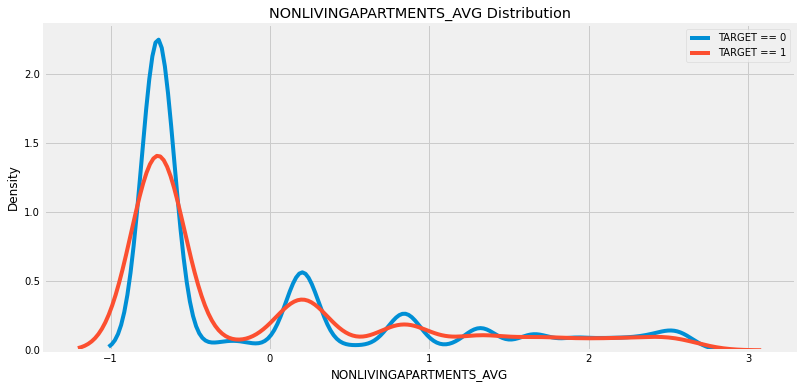

In [269]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_AVG', app_train)

In [270]:
columns = ['NONLIVINGAPARTMENTS_AVG']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### NONLIVINGAREA_AVG

In [271]:
app_train['NONLIVINGAREA_AVG'].value_counts()

0.0000    58735
0.0012      546
0.0044      454
0.0022      440
0.0031      415
          ...  
0.2989        1
0.1611        1
0.6946        1
0.2554        1
0.2879        1
Name: NONLIVINGAREA_AVG, Length: 3290, dtype: int64

In [272]:
app_train[['NONLIVINGAREA_AVG', 'TARGET']].corr()

NONLIVINGAREA_AVG    TARGET
NONLIVINGAREA_AVG           1.000000 -0.013578
TARGET                     -0.013578  1.000000

The correlation between NONLIVINGAREA_AVG and the TARGET is -0.0136
Median value for loan that was not repaid = 0.0028
Median value for loan that was repaid =     0.0036


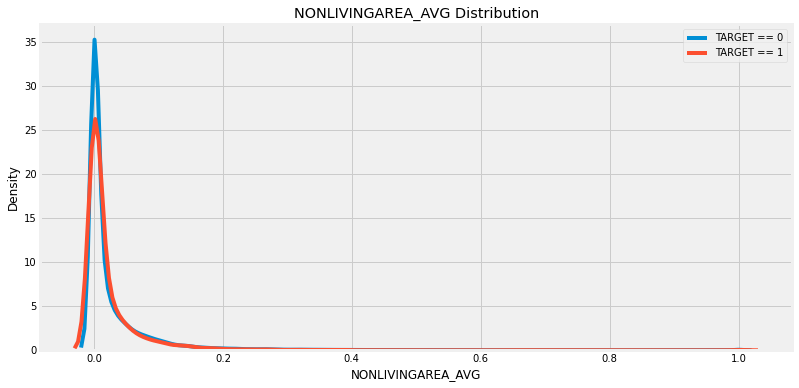

In [273]:
## 特徴量の分布
kde_target('NONLIVINGAREA_AVG', app_train)

In [274]:
## Yao-Johnson変換
#num_cols = ['NONLIVINGAREA_AVG']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['NONLIVINGAREA_AVG'] = pt.transform(app_train[num_cols])
#app_test['NONLIVINGAREA_AVG'] = pt.transform(app_test[num_cols])

In [275]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'NONLIVINGAREA_AVG']].corr()

In [276]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('NONLIVINGAREA_AVG', app_train)

### APARTMENTS_MODE

In [277]:
app_train['APARTMENTS_MODE'].value_counts()

0.0840    7522
0.0630    7451
0.0945    4757
0.0735    4388
0.0084    3970
          ... 
0.8445       1
0.9181       1
0.7458       1
0.8971       1
0.6586       1
Name: APARTMENTS_MODE, Length: 760, dtype: int64

In [278]:
app_train[['APARTMENTS_MODE', 'TARGET']].corr()

APARTMENTS_MODE    TARGET
APARTMENTS_MODE         1.000000 -0.027284
TARGET                 -0.027284  1.000000

The correlation between APARTMENTS_MODE and the TARGET is -0.0273
Median value for loan that was not repaid = 0.0809
Median value for loan that was repaid =     0.0840


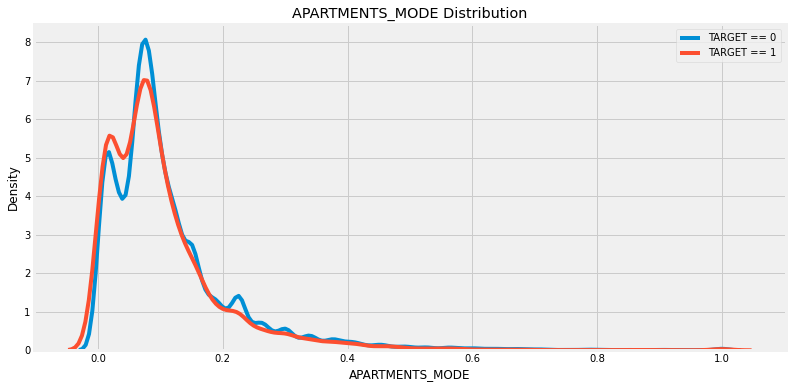

In [279]:
## 特徴量の分布
kde_target('APARTMENTS_MODE', app_train)

In [280]:
## Yao-Johnson変換
num_cols = ['APARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['APARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['APARTMENTS_MODE'] = pt.transform(app_test[num_cols])

In [281]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'APARTMENTS_MODE']].corr()

TARGET  APARTMENTS_MODE
TARGET           1.000000        -0.034398
APARTMENTS_MODE -0.034398         1.000000

The correlation between APARTMENTS_MODE and the TARGET is -0.0344
Median value for loan that was not repaid = -0.1265
Median value for loan that was repaid =     -0.0775


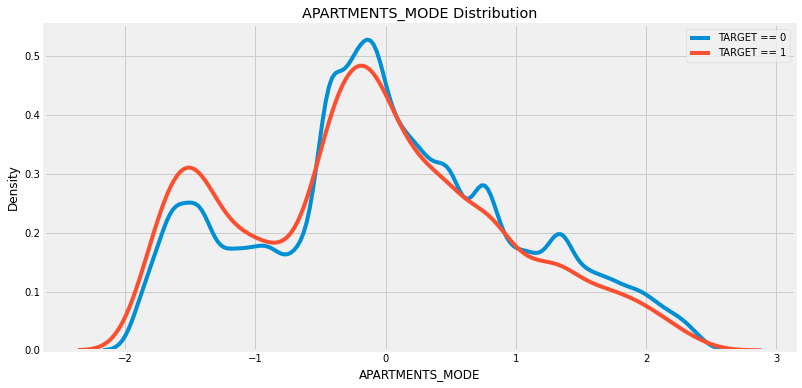

In [282]:
## Yao-Johnson変換後の特徴量の分布
kde_target('APARTMENTS_MODE', app_train)

### BASEMENTAREA_MODE

In [283]:
app_train['YEARS_BEGINEXPLUATATION_AVG'].value_counts()

 0.617045    4311
 0.425157    4189
 0.488413    4171
-0.226328    4123
 0.552373    4114
             ... 
-4.380490       1
-4.999256       1
-5.133044       1
-5.131377       1
-4.816931       1
Name: YEARS_BEGINEXPLUATATION_AVG, Length: 285, dtype: int64

In [284]:
app_train[['BASEMENTAREA_MODE', 'TARGET']].corr()

BASEMENTAREA_MODE    TARGET
BASEMENTAREA_MODE           1.000000 -0.019952
TARGET                     -0.019952  1.000000

The correlation between BASEMENTAREA_MODE and the TARGET is -0.0200
Median value for loan that was not repaid = 0.0716
Median value for loan that was repaid =     0.0748


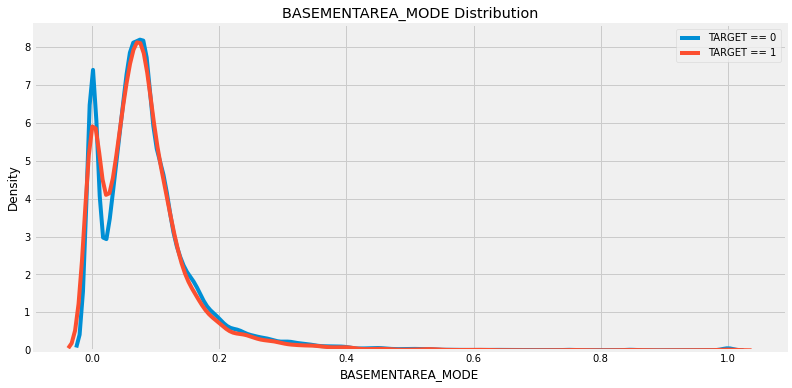

In [285]:
## 特徴量の分布
kde_target('BASEMENTAREA_MODE', app_train)

In [286]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_MODE'] = pt.transform(app_test[num_cols])

In [287]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_MODE']].corr()

TARGET  BASEMENTAREA_MODE
TARGET             1.000000          -0.020276
BASEMENTAREA_MODE -0.020276           1.000000

The correlation between BASEMENTAREA_MODE and the TARGET is -0.0203
Median value for loan that was not repaid = 0.0042
Median value for loan that was repaid =     0.0599


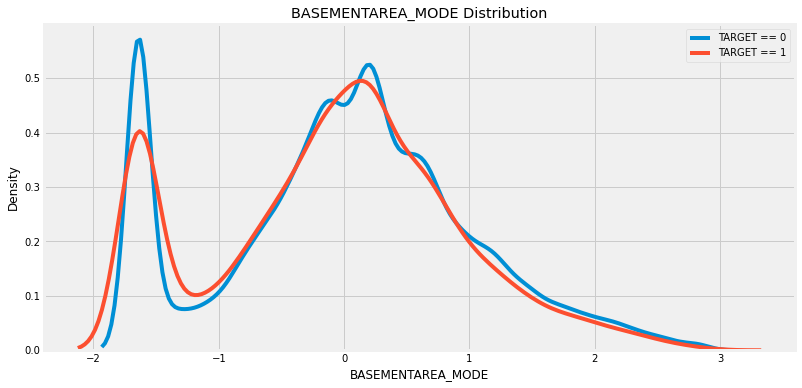

In [288]:
## Yao-Johnson変換後の特徴量の分布
kde_target('BASEMENTAREA_MODE', app_train)

### YEARS_BEGINEXPLUATATION_MODE

In [289]:
app_train['YEARS_BEGINEXPLUATATION_MODE'].value_counts()

0.9871    4291
0.9866    4173
0.9861    4167
0.9801    4110
0.9806    4083
          ... 
0.4518       1
0.4359       1
0.8987       1
0.9166       1
0.8937       1
Name: YEARS_BEGINEXPLUATATION_MODE, Length: 221, dtype: int64

In [290]:
app_train[['YEARS_BEGINEXPLUATATION_MODE', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MODE    TARGET
YEARS_BEGINEXPLUATATION_MODE                      1.000000 -0.009036
TARGET                                           -0.009036  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MODE and the TARGET is -0.0090
Median value for loan that was not repaid = 0.9806
Median value for loan that was repaid =     0.9816


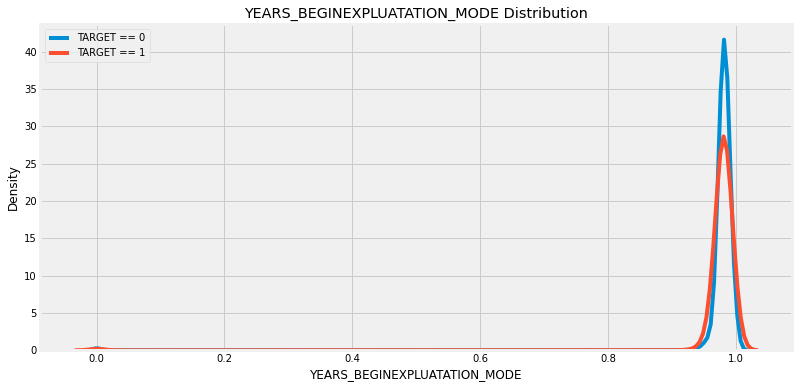

In [291]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MODE', app_train)

In [292]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_MODE'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_MODE'] = pt.transform(app_test[num_cols])

In [293]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_MODE']].corr()

TARGET  YEARS_BEGINEXPLUATATION_MODE
TARGET                        1.000000                     -0.027302
YEARS_BEGINEXPLUATATION_MODE -0.027302                      1.000000

The correlation between YEARS_BEGINEXPLUATATION_MODE and the TARGET is -0.0273
Median value for loan that was not repaid = -0.1390
Median value for loan that was repaid =     -0.0262


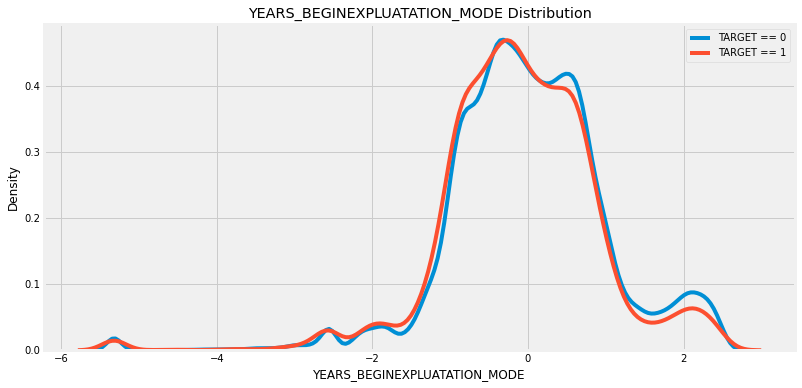

In [294]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MODE', app_train)

In [295]:
#columns = ['YEARS_BEGINEXPLUATATION_MODE']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### YEARS_BUILD_MODE

In [296]:
app_train['YEARS_BUILD_MODE'].value_counts()

0.8301    2960
0.8236    2879
0.7387    2789
0.8171    2763
0.8105    2755
          ... 
0.0853       2
0.0591       1
0.0983       1
0.0657       1
0.0330       1
Name: YEARS_BUILD_MODE, Length: 154, dtype: int64

In [297]:
app_train[['YEARS_BUILD_MODE', 'TARGET']].corr()

YEARS_BUILD_MODE    TARGET
YEARS_BUILD_MODE          1.000000 -0.022068
TARGET                   -0.022068  1.000000

The correlation between YEARS_BUILD_MODE and the TARGET is -0.0221
Median value for loan that was not repaid = 0.7550
Median value for loan that was repaid =     0.7648


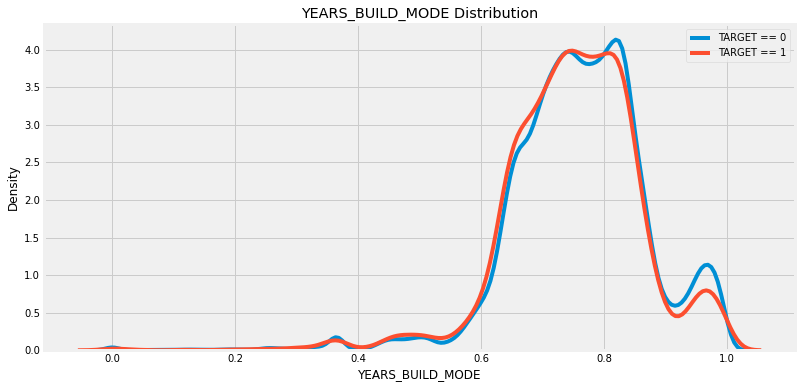

In [298]:
## 特徴量の分布
kde_target('YEARS_BUILD_MODE', app_train)

In [299]:
## Yao-Johnson変換
num_cols = ['YEARS_BUILD_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BUILD_MODE'] = pt.transform(app_train[num_cols])
app_test['YEARS_BUILD_MODE'] = pt.transform(app_test[num_cols])

In [300]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_MODE']].corr()

TARGET  YEARS_BUILD_MODE
TARGET            1.000000         -0.023509
YEARS_BUILD_MODE -0.023509          1.000000

The correlation between YEARS_BUILD_MODE and the TARGET is -0.0235
Median value for loan that was not repaid = -0.1281
Median value for loan that was repaid =     -0.0349


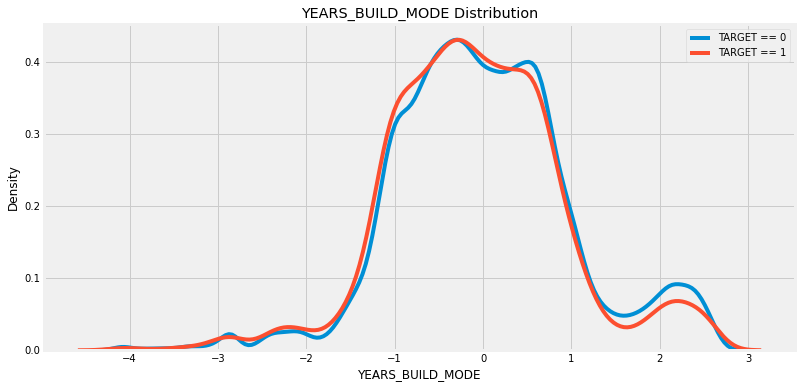

In [301]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BUILD_MODE', app_train)

### COMMONAREA_MODE

In [302]:
app_train['COMMONAREA_MODE'].value_counts()

0.0000    9690
0.0080     546
0.0079     543
0.0078     518
0.0081     416
          ... 
0.2154       1
0.2090       1
0.2568       1
0.2995       1
0.1635       1
Name: COMMONAREA_MODE, Length: 3128, dtype: int64

In [303]:
app_train[['COMMONAREA_MODE', 'TARGET']].corr()

COMMONAREA_MODE   TARGET
COMMONAREA_MODE          1.00000 -0.01634
TARGET                  -0.01634  1.00000

The correlation between COMMONAREA_MODE and the TARGET is -0.0163
Median value for loan that was not repaid = 0.0171
Median value for loan that was repaid =     0.0192


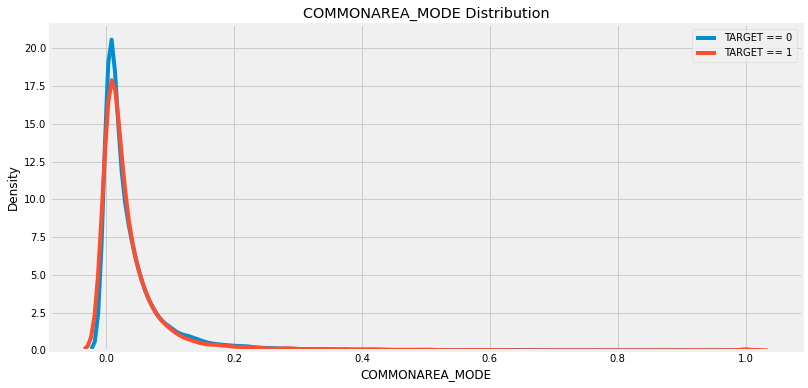

In [304]:
## 特徴量の分布
kde_target('COMMONAREA_MODE', app_train)

In [305]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_MODE'] = pt.transform(app_test[num_cols])

In [306]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_MODE']].corr()

TARGET  COMMONAREA_MODE
TARGET           1.000000        -0.017923
COMMONAREA_MODE -0.017923         1.000000

The correlation between COMMONAREA_MODE and the TARGET is -0.0179
Median value for loan that was not repaid = -0.3292
Median value for loan that was repaid =     -0.2366


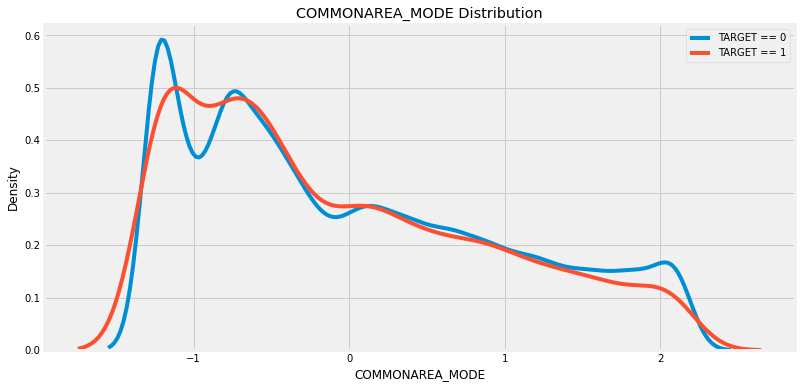

In [307]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_MODE', app_train)

### ELEVATORS_MODE

In [308]:
app_train['ELEVATORS_MODE'].value_counts()

0.0000    89498
0.0806    11629
0.1611     9675
0.2417     6379
0.1208     5734
0.0403     4876
0.2014     3962
0.3222     2887
0.2820     2135
0.4028     1554
0.3625     1308
0.4834     1094
0.4431      628
0.5639      491
0.6445      447
0.5236      253
0.6042      226
0.7250      219
1.0000      144
0.8056      137
0.6848       99
0.9667       87
0.8862       66
0.7653       38
0.8459       34
0.9264       20
Name: ELEVATORS_MODE, dtype: int64

In [309]:
app_train[['ELEVATORS_MODE', 'TARGET']].corr()

ELEVATORS_MODE    TARGET
ELEVATORS_MODE        1.000000 -0.032131
TARGET               -0.032131  1.000000

The correlation between ELEVATORS_MODE and the TARGET is -0.0321
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


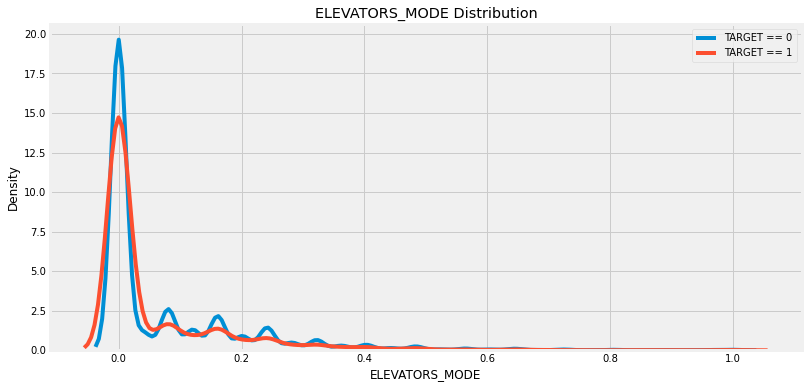

In [310]:
## 特徴量の分布
kde_target('ELEVATORS_MODE', app_train)

In [311]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_MODE'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_MODE'] = pt.transform(app_test[num_cols])

In [312]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_MODE']].corr()

TARGET  ELEVATORS_MODE
TARGET          1.000000       -0.036766
ELEVATORS_MODE -0.036766        1.000000

The correlation between ELEVATORS_MODE and the TARGET is -0.0368
Median value for loan that was not repaid = -0.7406
Median value for loan that was repaid =     -0.7406


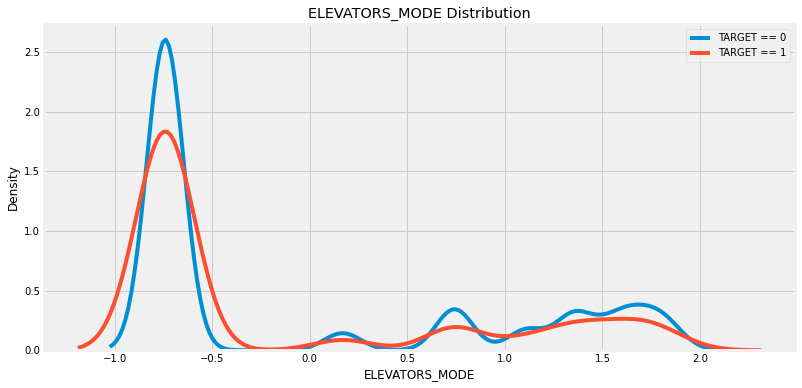

In [313]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_MODE', app_train)

### ENTRANCES_MODE

In [314]:
app_train['ENTRANCES_MODE'].value_counts()

0.1379    36041
0.0690    26704
0.1034    20533
0.2069    19678
0.0345    19428
0.1724     8986
0.2759     8036
0.2414     4013
0.3448     2046
0.3103     2014
0.4138     1212
0.3793      977
0.4828      500
0.4483      431
0.0000      387
0.5517      351
0.5172      301
0.6207      241
0.5862      186
1.0000      152
0.6897      116
0.6552       65
0.8966       52
0.7586       48
0.7241       44
0.8276       42
0.7931       39
0.9655       25
0.9310       21
0.8621       14
Name: ENTRANCES_MODE, dtype: int64

In [315]:
app_train[['ENTRANCES_MODE', 'TARGET']].corr()

ENTRANCES_MODE    TARGET
ENTRANCES_MODE        1.000000 -0.017387
TARGET               -0.017387  1.000000

The correlation between ENTRANCES_MODE and the TARGET is -0.0174
Median value for loan that was not repaid = 0.1379
Median value for loan that was repaid =     0.1379


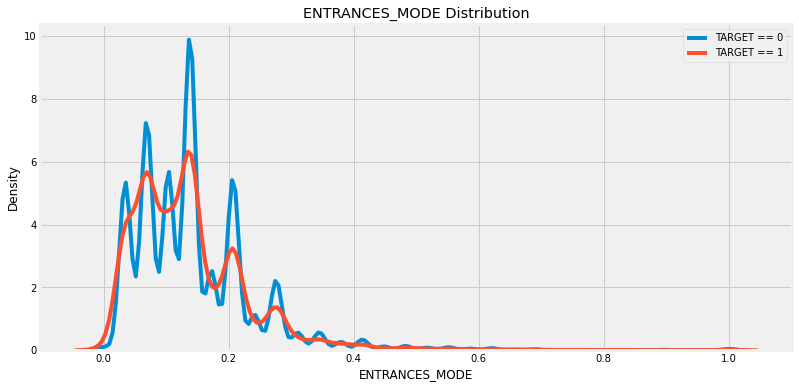

In [316]:
## 特徴量の分布
kde_target('ENTRANCES_MODE', app_train)

In [317]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_MODE'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_MODE'] = pt.transform(app_test[num_cols])

In [318]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_MODE']].corr()

TARGET  ENTRANCES_MODE
TARGET          1.000000       -0.021029
ENTRANCES_MODE -0.021029        1.000000

The correlation between ENTRANCES_MODE and the TARGET is -0.0210
Median value for loan that was not repaid = 0.1698
Median value for loan that was repaid =     0.1698


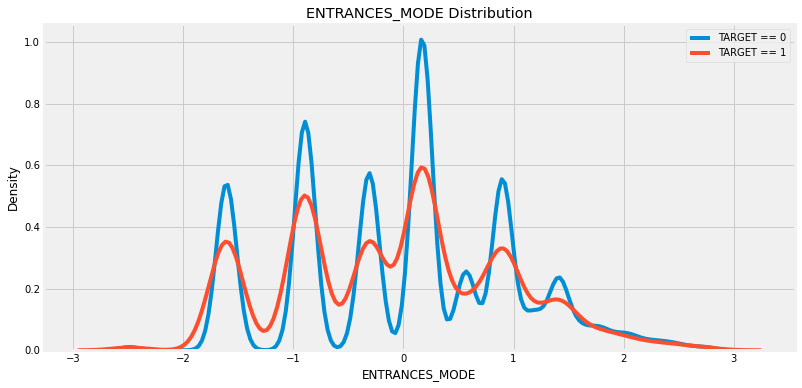

In [319]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_MODE', app_train)

### FLOORSMAX_MODE

In [320]:
app_train['FLOORSMAX_MODE'].value_counts()

0.1667    65550
0.3333    34373
0.0417    15616
0.3750     8321
0.1250     7267
0.0833     6785
0.0000     3415
0.4583     3216
0.6250     2075
0.5417     1836
0.6667     1710
0.2083     1505
0.2500      572
0.2917      511
0.5833      391
0.4167      236
0.8750      229
0.7083      199
0.5000      184
1.0000      164
0.7500      124
0.9583       94
0.7917       58
0.9167       38
0.8333       22
Name: FLOORSMAX_MODE, dtype: int64

In [321]:
app_train[['FLOORSMAX_MODE', 'TARGET']].corr()

FLOORSMAX_MODE    TARGET
FLOORSMAX_MODE        1.000000 -0.043226
TARGET               -0.043226  1.000000

The correlation between FLOORSMAX_MODE and the TARGET is -0.0432
Median value for loan that was not repaid = 0.1667
Median value for loan that was repaid =     0.1667


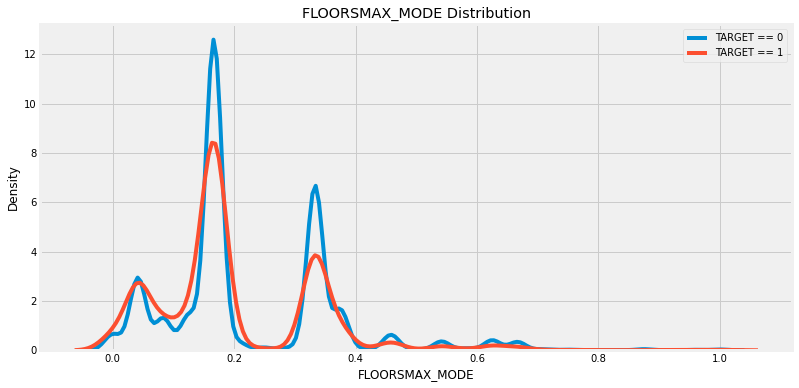

In [322]:
## 特徴量の分布
kde_target('FLOORSMAX_MODE', app_train)

In [323]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_MODE'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_MODE'] = pt.transform(app_test[num_cols])

In [324]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_MODE']].corr()

TARGET  FLOORSMAX_MODE
TARGET          1.000000       -0.045505
FLOORSMAX_MODE -0.045505        1.000000

The correlation between FLOORSMAX_MODE and the TARGET is -0.0455
Median value for loan that was not repaid = -0.2604
Median value for loan that was repaid =     -0.2604


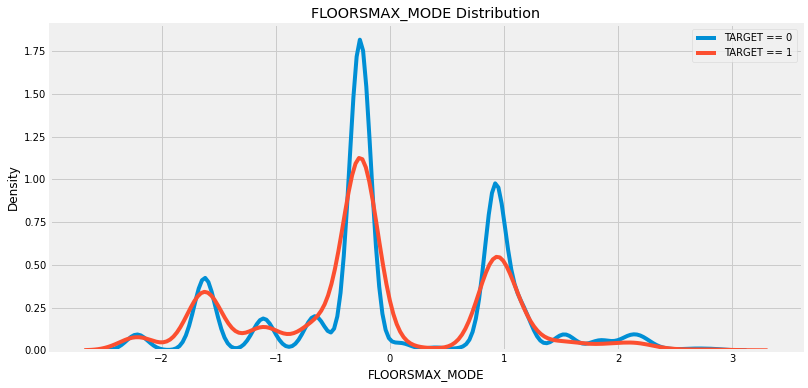

In [325]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_MODE', app_train)

### FLOORSMIN_MODE

In [326]:
app_train['LANDAREA_MODE'].value_counts()

0.0000    17453
0.0194      208
0.0645      193
0.0484      192
0.0323      188
          ...  
0.2428        1
0.4716        1
0.6044        1
0.3757        1
0.2723        1
Name: LANDAREA_MODE, Length: 3563, dtype: int64

In [327]:
app_train[['LANDAREA_MODE', 'TARGET']].corr()

LANDAREA_MODE    TARGET
LANDAREA_MODE       1.000000 -0.010174
TARGET             -0.010174  1.000000

The correlation between LANDAREA_MODE and the TARGET is -0.0102
Median value for loan that was not repaid = 0.0428
Median value for loan that was repaid =     0.0461


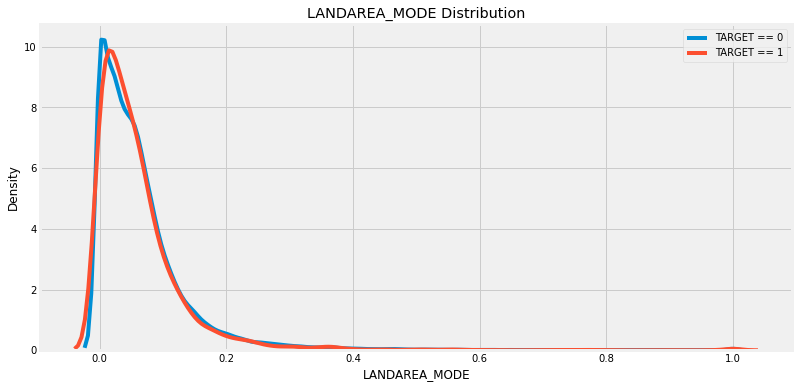

In [328]:
## 特徴量の分布
kde_target('LANDAREA_MODE', app_train)

In [329]:
## Yao-Johnson変換
num_cols = ['LANDAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_MODE'] = pt.transform(app_test[num_cols])

In [330]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_MODE']].corr()

TARGET  LANDAREA_MODE
TARGET         1.000000      -0.011957
LANDAREA_MODE -0.011957       1.000000

The correlation between LANDAREA_MODE and the TARGET is -0.0120
Median value for loan that was not repaid = -0.0911
Median value for loan that was repaid =     -0.0120


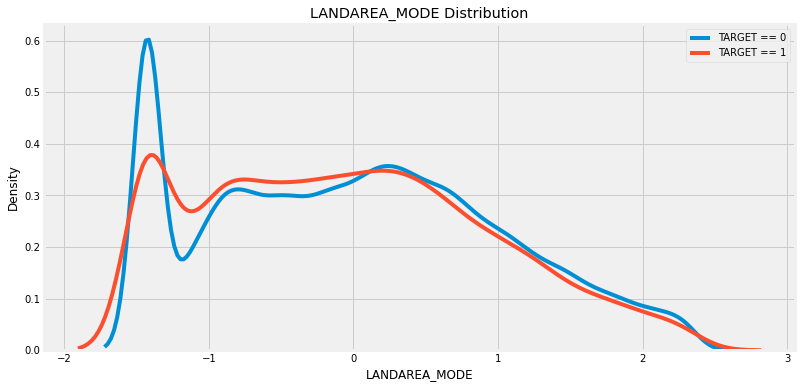

In [331]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_MODE', app_train)

### LIVINGAPARTMENTS_MODE

In [332]:
app_train['LIVINGAPARTMENTS_MODE'].value_counts()

0.0551    4931
0.0735    4797
0.0826    2966
0.0643    2853
0.0918    2069
          ... 
0.7062       1
0.6042       1
0.5638       1
0.6795       1
0.6538       1
Name: LIVINGAPARTMENTS_MODE, Length: 736, dtype: int64

In [333]:
app_train[['LIVINGAPARTMENTS_MODE', 'TARGET']].corr()

LIVINGAPARTMENTS_MODE    TARGET
LIVINGAPARTMENTS_MODE               1.000000 -0.023393
TARGET                             -0.023393  1.000000

The correlation between LIVINGAPARTMENTS_MODE and the TARGET is -0.0234
Median value for loan that was not repaid = 0.0735
Median value for loan that was repaid =     0.0771


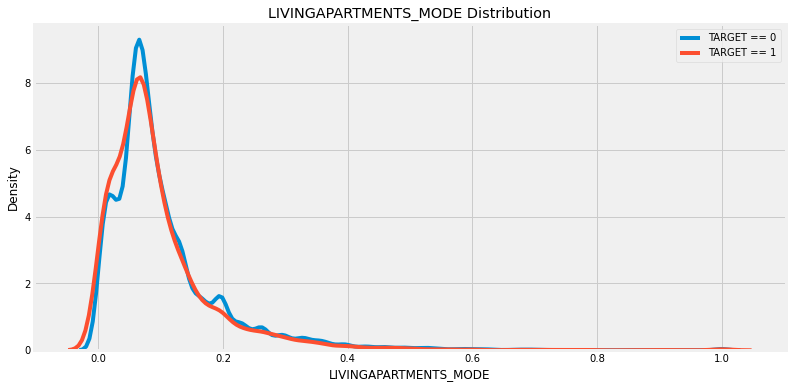

In [334]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_MODE', app_train)

In [335]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_MODE'] = pt.transform(app_test[num_cols])

In [336]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_MODE']].corr()

TARGET  LIVINGAPARTMENTS_MODE
TARGET                 1.000000              -0.030042
LIVINGAPARTMENTS_MODE -0.030042               1.000000

The correlation between LIVINGAPARTMENTS_MODE and the TARGET is -0.0300
Median value for loan that was not repaid = -0.1647
Median value for loan that was repaid =     -0.0994


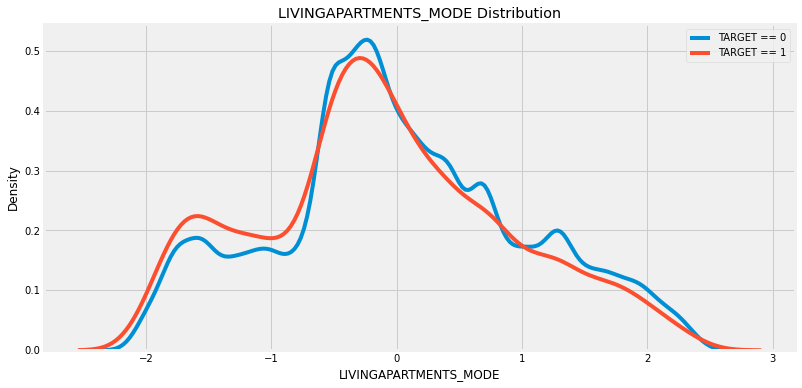

In [337]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_MODE', app_train)

### LIVINGAREA_MODE

In [338]:
app_train[['LIVINGAREA_MODE', 'TARGET']].corr()

LIVINGAREA_MODE    TARGET
LIVINGAREA_MODE         1.000000 -0.030685
TARGET                 -0.030685  1.000000

The correlation between LIVINGAREA_MODE and the TARGET is -0.0307
Median value for loan that was not repaid = 0.0668
Median value for loan that was repaid =     0.0734


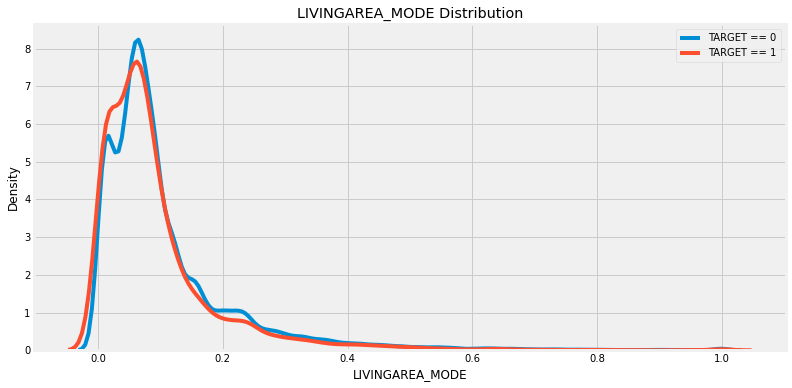

In [339]:
## 特徴量の分布
kde_target('LIVINGAREA_MODE', app_train)

In [340]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_MODE'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_MODE'] = pt.transform(app_test[num_cols])

In [341]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_MODE']].corr()

TARGET  LIVINGAREA_MODE
TARGET           1.00000         -0.03945
LIVINGAREA_MODE -0.03945          1.00000

The correlation between LIVINGAREA_MODE and the TARGET is -0.0395
Median value for loan that was not repaid = -0.1944
Median value for loan that was repaid =     -0.0772


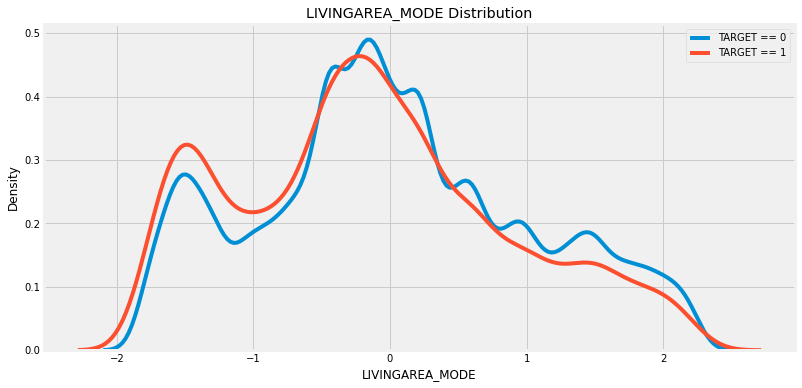

In [342]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_MODE', app_train)

### NONLIVINGAPARTMENTS_MODE

In [343]:
app_train[['NONLIVINGAPARTMENTS_MODE', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MODE    TARGET
NONLIVINGAPARTMENTS_MODE                  1.000000 -0.001557
TARGET                                   -0.001557  1.000000

The correlation between NONLIVINGAPARTMENTS_MODE and the TARGET is -0.0016
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


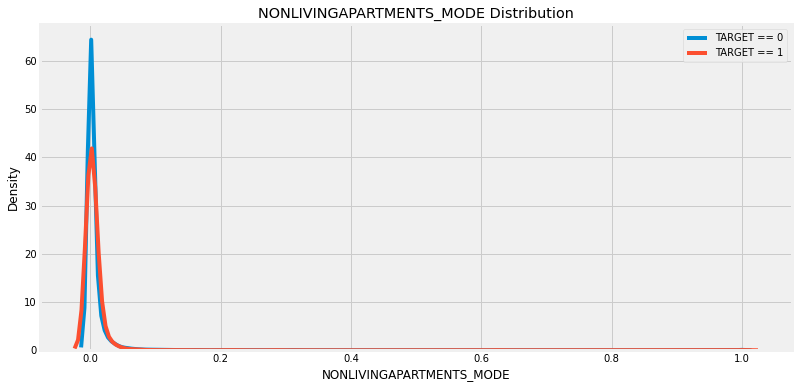

In [344]:
## 特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MODE', app_train)

In [345]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_MODE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_MODE'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_MODE'] = pt.transform(app_test[num_cols])

In [346]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_MODE']].corr()

TARGET  NONLIVINGAPARTMENTS_MODE
TARGET                    1.000000                 -0.005946
NONLIVINGAPARTMENTS_MODE -0.005946                  1.000000

The correlation between NONLIVINGAPARTMENTS_MODE and the TARGET is -0.0059
Median value for loan that was not repaid = -0.6638
Median value for loan that was repaid =     -0.6638


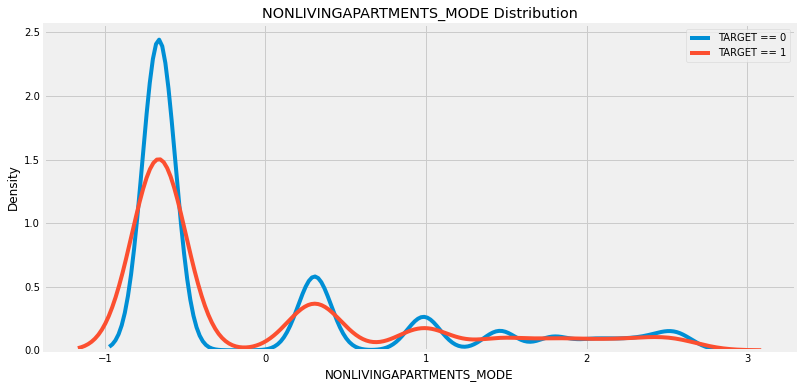

In [347]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MODE', app_train)

In [348]:
columns = ['NONLIVINGAPARTMENTS_MODE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### NONLIVINGAREA_MODE

In [349]:
app_train[['NONLIVINGAREA_MODE', 'TARGET']].corr()

NONLIVINGAREA_MODE    TARGET
NONLIVINGAREA_MODE            1.000000 -0.012711
TARGET                       -0.012711  1.000000

The correlation between NONLIVINGAREA_MODE and the TARGET is -0.0127
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0011


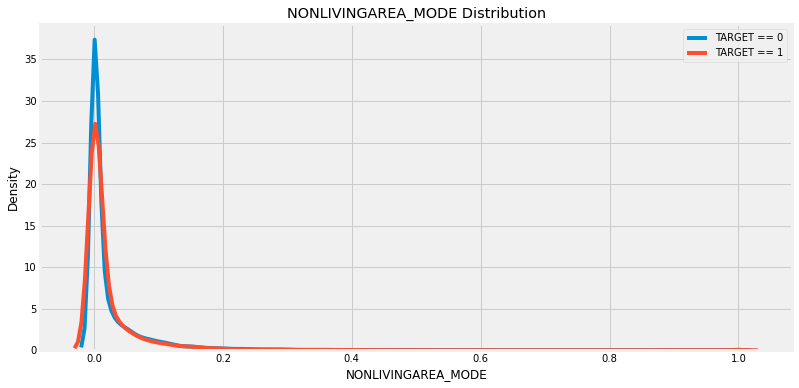

In [350]:
## 特徴量の分布
kde_target('NONLIVINGAREA_MODE', app_train)

In [351]:
## Yao-Johnson変換
#num_cols = ['NONLIVINGAREA_MODE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['NONLIVINGAREA_MODE'] = pt.transform(app_train[num_cols])
#app_test['NONLIVINGAREA_MODE'] = pt.transform(app_test[num_cols])

In [352]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'NONLIVINGAREA_MODE']].corr()

In [353]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('NONLIVINGAREA_MODE', app_train)

### APARTMENTS_MEDI

In [354]:
app_train[['BASEMENTAREA_MEDI', 'TARGET']].corr()

BASEMENTAREA_MEDI    TARGET
BASEMENTAREA_MEDI           1.000000 -0.022081
TARGET                     -0.022081  1.000000

The correlation between BASEMENTAREA_MEDI and the TARGET is -0.0221
Median value for loan that was not repaid = 0.0718
Median value for loan that was repaid =     0.0761


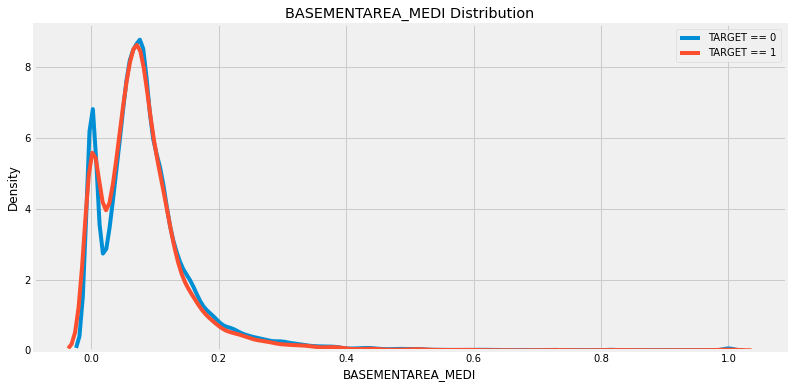

In [355]:
## 特徴量の分布
kde_target('BASEMENTAREA_MEDI', app_train)

In [356]:
## Yao-Johnson変換
num_cols = ['BASEMENTAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['BASEMENTAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['BASEMENTAREA_MEDI'] = pt.transform(app_test[num_cols])

In [357]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'BASEMENTAREA_MEDI']].corr()

TARGET  BASEMENTAREA_MEDI
TARGET             1.000000          -0.023256
BASEMENTAREA_MEDI -0.023256           1.000000

The correlation between BASEMENTAREA_MEDI and the TARGET is -0.0233
Median value for loan that was not repaid = -0.0131
Median value for loan that was repaid =     0.0632


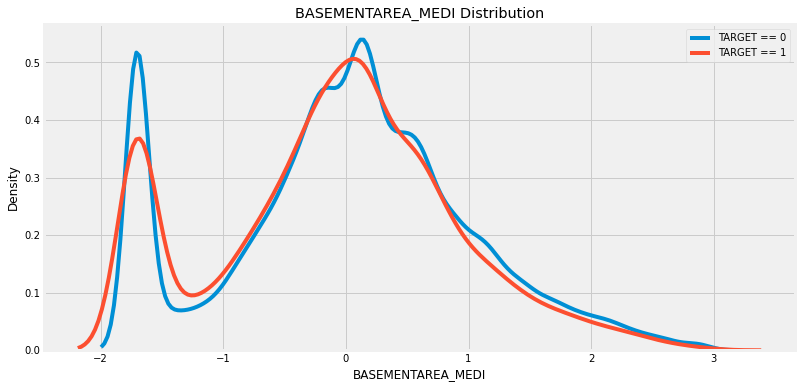

In [358]:
## Yao-Johnson変換後の特徴量の分布
kde_target('BASEMENTAREA_MEDI', app_train)

### YEARS_BEGINEXPLUATATION_MEDI

In [359]:
app_train[['YEARS_BEGINEXPLUATATION_MEDI', 'TARGET']].corr()

YEARS_BEGINEXPLUATATION_MEDI    TARGET
YEARS_BEGINEXPLUATATION_MEDI                      1.000000 -0.009993
TARGET                                           -0.009993  1.000000

The correlation between YEARS_BEGINEXPLUATATION_MEDI and the TARGET is -0.0100
Median value for loan that was not repaid = 0.9811
Median value for loan that was repaid =     0.9821


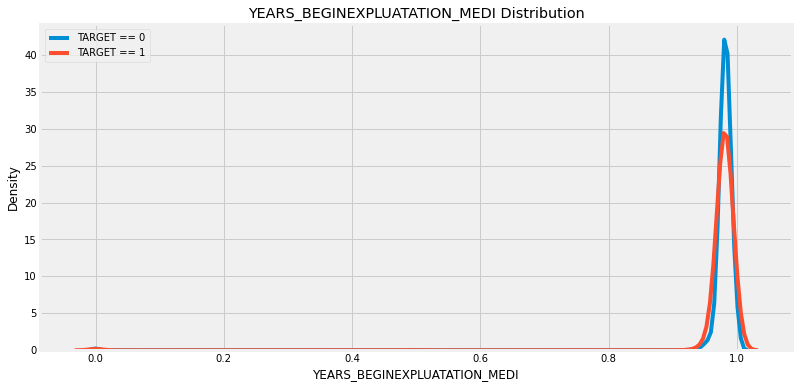

In [360]:
## 特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MEDI', app_train)

In [361]:
## Yao-Johnson変換
num_cols = ['YEARS_BEGINEXPLUATATION_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BEGINEXPLUATATION_MEDI'] = pt.transform(app_train[num_cols])
app_test['YEARS_BEGINEXPLUATATION_MEDI'] = pt.transform(app_test[num_cols])

In [362]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BEGINEXPLUATATION_MEDI']].corr()

TARGET  YEARS_BEGINEXPLUATATION_MEDI
TARGET                        1.000000                     -0.027864
YEARS_BEGINEXPLUATATION_MEDI -0.027864                      1.000000

The correlation between YEARS_BEGINEXPLUATATION_MEDI and the TARGET is -0.0279
Median value for loan that was not repaid = -0.1127
Median value for loan that was repaid =     0.0021


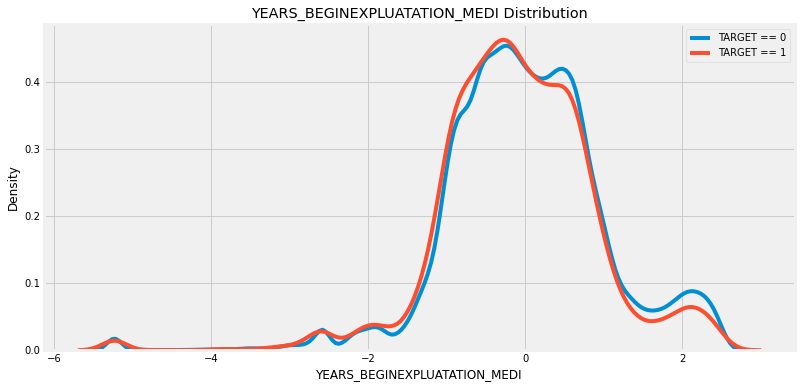

In [363]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BEGINEXPLUATATION_MEDI', app_train)

In [364]:
#columns = ['YEARS_BEGINEXPLUATATION_MEDI']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### YEARS_BUILD_MEDI

In [365]:
app_train[['YEARS_BUILD_MEDI', 'TARGET']].corr()

YEARS_BUILD_MEDI    TARGET
YEARS_BUILD_MEDI          1.000000 -0.022326
TARGET                   -0.022326  1.000000

The correlation between YEARS_BUILD_MEDI and the TARGET is -0.0223
Median value for loan that was not repaid = 0.7518
Median value for loan that was repaid =     0.7585


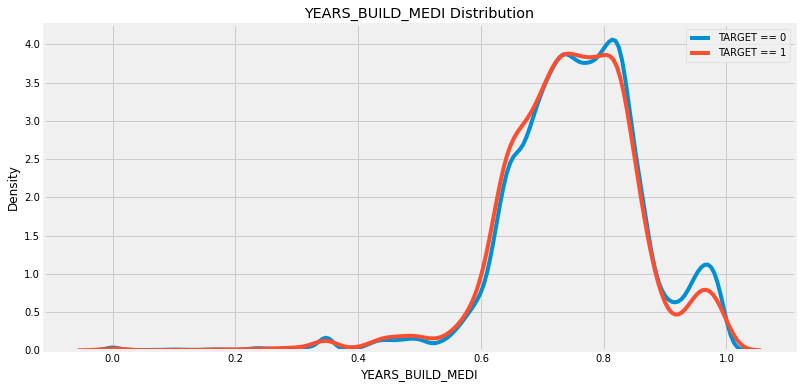

In [366]:
## 特徴量の分布
kde_target('YEARS_BUILD_MEDI', app_train)

In [367]:
## Yao-Johnson変換
num_cols = ['YEARS_BUILD_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['YEARS_BUILD_MEDI'] = pt.transform(app_train[num_cols])
app_test['YEARS_BUILD_MEDI'] = pt.transform(app_test[num_cols])

In [368]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'YEARS_BUILD_MEDI']].corr()

TARGET  YEARS_BUILD_MEDI
TARGET            1.000000         -0.023725
YEARS_BUILD_MEDI -0.023725          1.000000

The correlation between YEARS_BUILD_MEDI and the TARGET is -0.0237
Median value for loan that was not repaid = -0.1197
Median value for loan that was repaid =     -0.0572


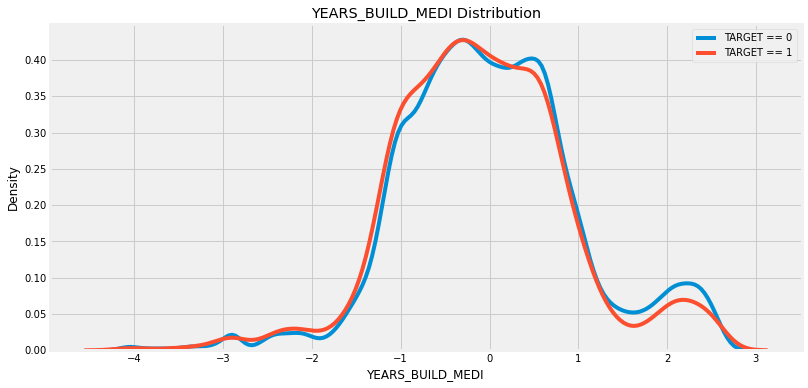

In [369]:
## Yao-Johnson変換後の特徴量の分布
kde_target('YEARS_BUILD_MEDI', app_train)

### COMMONAREA_MEDI

In [370]:
app_train[['COMMONAREA_MEDI', 'TARGET']].corr()

COMMONAREA_MEDI    TARGET
COMMONAREA_MEDI         1.000000 -0.018573
TARGET                 -0.018573  1.000000

The correlation between COMMONAREA_MEDI and the TARGET is -0.0186
Median value for loan that was not repaid = 0.0183
Median value for loan that was repaid =     0.0210


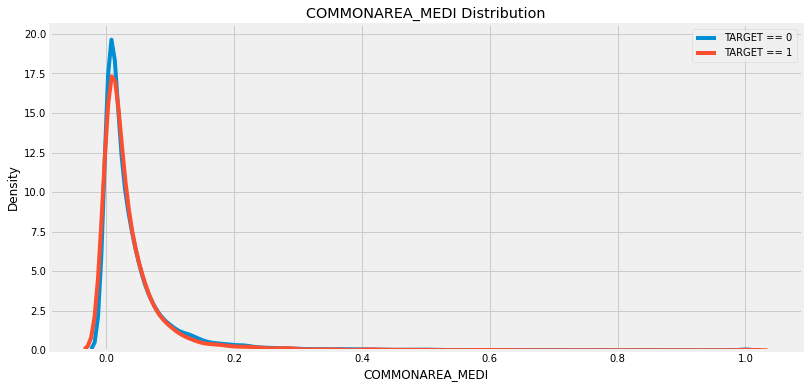

In [371]:
## 特徴量の分布
kde_target('COMMONAREA_MEDI', app_train)

In [372]:
## Yao-Johnson変換
num_cols = ['COMMONAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['COMMONAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['COMMONAREA_MEDI'] = pt.transform(app_test[num_cols])

In [373]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'COMMONAREA_MEDI']].corr()

TARGET  COMMONAREA_MEDI
TARGET           1.000000        -0.020225
COMMONAREA_MEDI -0.020225         1.000000

The correlation between COMMONAREA_MEDI and the TARGET is -0.0202
Median value for loan that was not repaid = -0.3278
Median value for loan that was repaid =     -0.2143


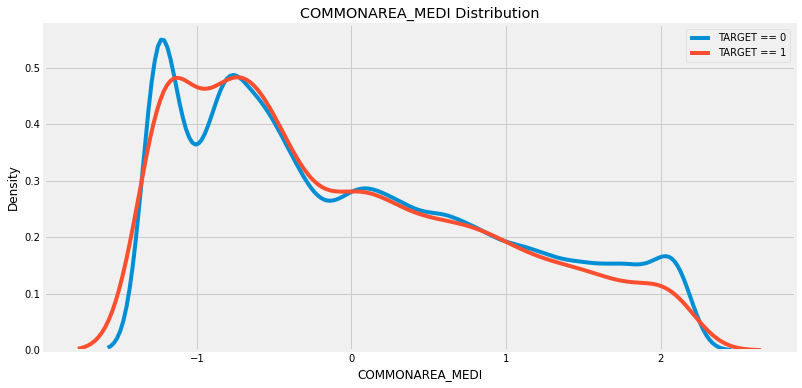

In [374]:
## Yao-Johnson変換後の特徴量の分布
kde_target('COMMONAREA_MEDI', app_train)

### ELEVATORS_MEDI

In [375]:
app_train['ELEVATORS_MEDI'].value_counts()

0.00    87026
0.08    10832
0.16     9278
0.24     6392
0.12     5946
0.04     4852
0.20     4162
0.32     2937
0.28     2317
0.40     1604
0.36     1405
0.48     1096
0.44      715
0.10      543
0.56      493
0.64      454
0.14      388
0.06      388
0.02      368
0.52      290
0.18      280
0.60      248
0.22      226
0.72      224
1.00      158
0.26      145
0.80      140
0.68      112
0.30       94
0.96       81
0.34       80
0.88       68
0.38       62
0.76       45
0.42       32
0.84       32
0.46       23
0.92       20
0.50       16
0.54       10
0.78       10
0.58        6
0.74        6
0.90        6
0.66        5
0.62        5
Name: ELEVATORS_MEDI, dtype: int64

In [376]:
app_train[['ELEVATORS_MEDI', 'TARGET']].corr()

ELEVATORS_MEDI    TARGET
ELEVATORS_MEDI        1.000000 -0.033863
TARGET               -0.033863  1.000000

The correlation between ELEVATORS_MEDI and the TARGET is -0.0339
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


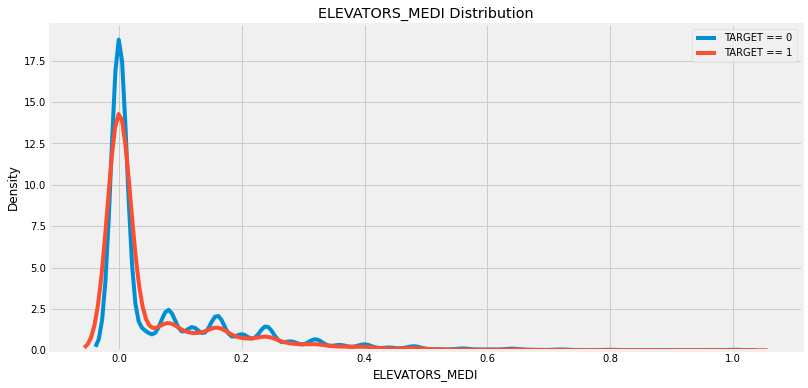

In [377]:
## 特徴量の分布
kde_target('ELEVATORS_MEDI', app_train)

In [378]:
## Yao-Johnson変換
num_cols = ['ELEVATORS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ELEVATORS_MEDI'] = pt.transform(app_train[num_cols])
app_test['ELEVATORS_MEDI'] = pt.transform(app_test[num_cols])

In [379]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ELEVATORS_MEDI']].corr()

TARGET  ELEVATORS_MEDI
TARGET          1.000000       -0.038201
ELEVATORS_MEDI -0.038201        1.000000

The correlation between ELEVATORS_MEDI and the TARGET is -0.0382
Median value for loan that was not repaid = -0.7618
Median value for loan that was repaid =     -0.7618


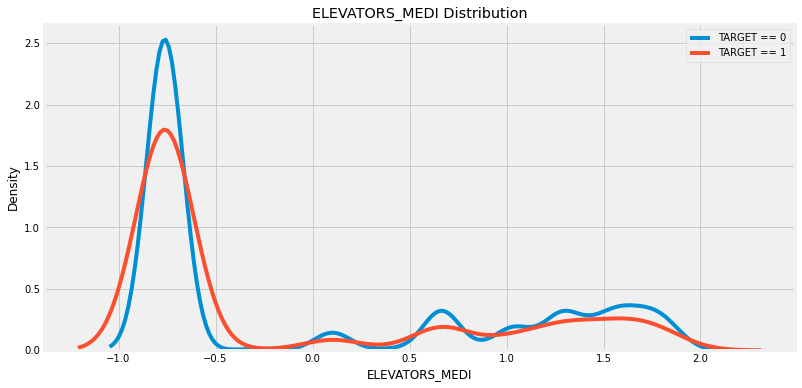

In [380]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ELEVATORS_MEDI', app_train)

### ENTRANCES_MEDI

In [381]:
app_train['ENTRANCES_MEDI'].value_counts()

0.1379    35535
0.0690    24193
0.1034    20492
0.2069    19750
0.0345    16150
0.1724     9566
0.2759     8048
0.2414     4318
0.3448     2108
0.3103     2086
0.0862     1352
0.1207     1228
0.4138     1198
0.3793     1010
0.1552      788
0.0517      611
0.1897      554
0.4828      503
0.4483      438
0.5517      352
0.0000      329
0.5172      304
0.2241      278
0.6207      241
0.5862      187
0.2586      169
1.0000      153
0.6897      116
0.2931      106
0.6552       68
0.3276       59
0.8966       52
0.7586       48
0.7241       44
0.8276       42
0.3621       39
0.7931       39
0.4310       31
0.9655       25
0.9310       21
0.3966       14
0.8621       14
0.4655       12
0.0172        7
0.5690        4
0.5000        1
Name: ENTRANCES_MEDI, dtype: int64

In [382]:
app_train[['ENTRANCES_MEDI', 'TARGET']].corr()

ENTRANCES_MEDI    TARGET
ENTRANCES_MEDI        1.000000 -0.019025
TARGET               -0.019025  1.000000

In [383]:
## Yao-Johnson変換
num_cols = ['ENTRANCES_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['ENTRANCES_MEDI'] = pt.transform(app_train[num_cols])
app_test['ENTRANCES_MEDI'] = pt.transform(app_test[num_cols])

In [384]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'ENTRANCES_MEDI']].corr()

TARGET  ENTRANCES_MEDI
TARGET          1.000000       -0.023286
ENTRANCES_MEDI -0.023286        1.000000

The correlation between ENTRANCES_MEDI and the TARGET is -0.0233
Median value for loan that was not repaid = 0.1110
Median value for loan that was repaid =     0.1110


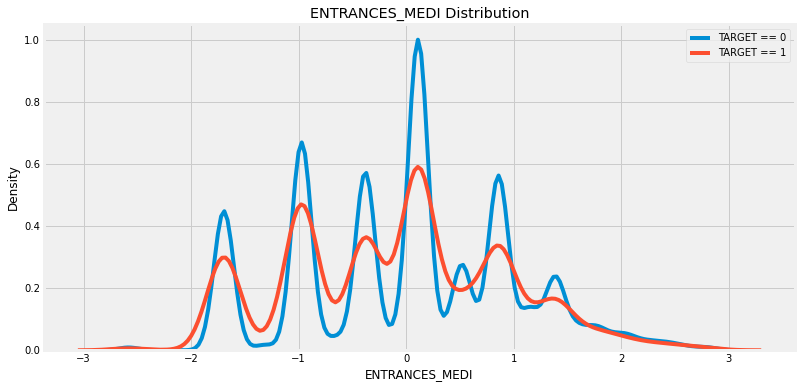

In [385]:
## Yao-Johnson変換後の特徴量の分布
kde_target('ENTRANCES_MEDI', app_train)

### FLOORSMAX_MEDI

In [386]:
app_train['FLOORSMAX_MEDI'].value_counts()

0.1667    63607
0.3333    33279
0.0417    14832
0.3750     8207
0.1250     7079
0.0833     6657
0.4583     3089
0.0000     2995
0.6250     2042
0.5417     1860
0.2500     1684
0.6667     1675
0.2083     1544
0.2917      567
0.1042      460
0.3542      459
0.5833      439
0.3958      346
0.4167      329
0.1458      321
0.5000      312
0.2708      291
0.1875      245
0.8750      223
0.4792      220
0.7083      204
1.0000      170
0.4375      138
0.7500      136
0.0625      132
0.3125      131
0.2292      128
0.0208      126
0.6042      115
0.9583       95
0.7917       61
0.5208       47
0.5625       46
0.8333       39
0.9167       37
0.6458       30
0.7708       27
0.6875       24
0.8125       23
0.7292       10
0.9375        4
0.8542        3
0.8958        2
0.9792        1
Name: FLOORSMAX_MEDI, dtype: int64

In [387]:
app_train[['FLOORSMAX_MEDI', 'TARGET']].corr()

FLOORSMAX_MEDI    TARGET
FLOORSMAX_MEDI        1.000000 -0.043768
TARGET               -0.043768  1.000000

The correlation between FLOORSMAX_MEDI and the TARGET is -0.0438
Median value for loan that was not repaid = 0.1667
Median value for loan that was repaid =     0.1667


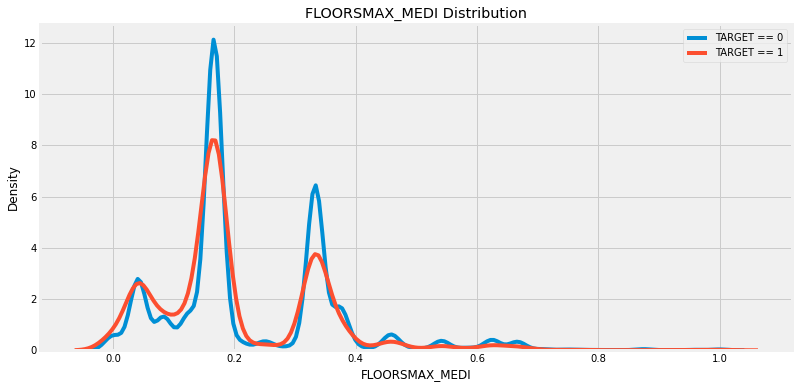

In [388]:
## 特徴量の分布
kde_target('FLOORSMAX_MEDI', app_train)

In [389]:
## Yao-Johnson変換
num_cols = ['FLOORSMAX_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['FLOORSMAX_MEDI'] = pt.transform(app_train[num_cols])
app_test['FLOORSMAX_MEDI'] = pt.transform(app_test[num_cols])

In [390]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'FLOORSMAX_MEDI']].corr()

TARGET  FLOORSMAX_MEDI
TARGET          1.000000       -0.046117
FLOORSMAX_MEDI -0.046117        1.000000

The correlation between FLOORSMAX_MEDI and the TARGET is -0.0461
Median value for loan that was not repaid = -0.2866
Median value for loan that was repaid =     -0.2866


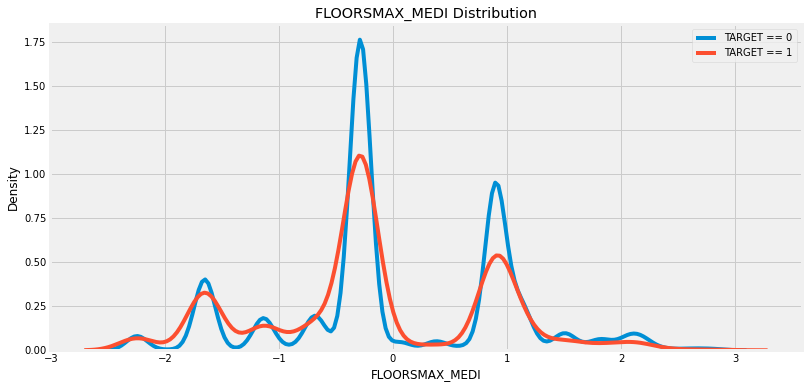

In [391]:
## Yao-Johnson変換後の特徴量の分布
kde_target('FLOORSMAX_MEDI', app_train)

### FLOORSMIN_MEDI

In [392]:
app_train['FLOORSMIN_MEDI'].value_counts()

0.2083    33737
0.3750    18538
0.0417    18090
0.0833     5131
0.4167     4068
0.1667     3570
0.1250     3373
0.0000     2351
0.5000     1835
0.6667     1261
0.7083     1108
0.5833     1057
0.2917      852
0.2500      779
0.3333      341
0.6250      235
0.5417      212
0.3958      205
0.4375      186
0.1458      180
0.1875      159
0.4583      154
0.3125      148
1.0000      147
0.9167      130
0.2292      121
0.7500      116
0.1042      106
0.2708      104
0.5208       81
0.3542       79
0.7917       64
0.4792       61
0.0625       51
0.0208       50
0.6458       49
0.8333       27
0.5625       19
0.8750       16
0.6042       16
0.9583       14
0.8125       12
0.7292       10
0.6875        9
0.7708        7
0.9792        5
0.8542        5
Name: FLOORSMIN_MEDI, dtype: int64

In [393]:
app_train[['FLOORSMIN_MEDI', 'TARGET']].corr()

FLOORSMIN_MEDI    TARGET
FLOORSMIN_MEDI        1.000000 -0.033394
TARGET               -0.033394  1.000000

The correlation between FLOORSMIN_MEDI and the TARGET is -0.0334
Median value for loan that was not repaid = 0.2083
Median value for loan that was repaid =     0.2083


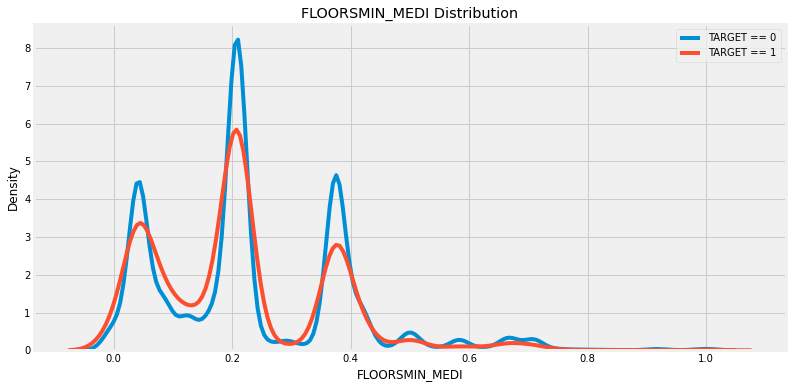

In [394]:
## 特徴量の分布
kde_target('FLOORSMIN_MEDI', app_train)

In [395]:
## Yao-Johnson変換
#num_cols = ['FLOORSMIN_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['FLOORSMIN_MEDI'] = pt.transform(app_train[num_cols])
#app_test['FLOORSMIN_MEDI'] = pt.transform(app_test[num_cols])

In [396]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'FLOORSMIN_MEDI']].corr()

In [397]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('FLOORSMIN_MEDI', app_train)

### LANDAREA_MEDI

In [398]:
app_train['LANDAREA_MEDI'].value_counts()

0.0000    15919
0.0193      197
0.0642      194
0.0482      186
0.0143      180
          ...  
0.7523        1
0.3480        1
0.3288        1
0.8106        1
0.2709        1
Name: LANDAREA_MEDI, Length: 3560, dtype: int64

In [399]:
app_train[['LANDAREA_MEDI', 'TARGET']].corr()

LANDAREA_MEDI    TARGET
LANDAREA_MEDI       1.000000 -0.011256
TARGET             -0.011256  1.000000

The correlation between LANDAREA_MEDI and the TARGET is -0.0113
Median value for loan that was not repaid = 0.0454
Median value for loan that was repaid =     0.0489


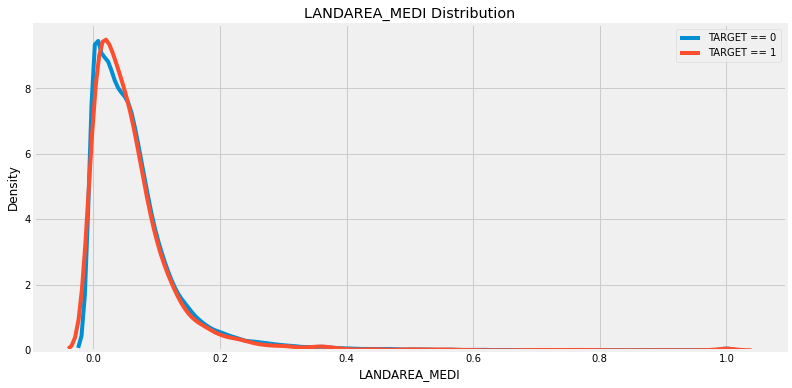

In [400]:
## 特徴量の分布
kde_target('LANDAREA_MEDI', app_train)

In [401]:
## Yao-Johnson変換
num_cols = ['LANDAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LANDAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['LANDAREA_MEDI'] = pt.transform(app_test[num_cols])

In [402]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LANDAREA_MEDI']].corr()

TARGET  LANDAREA_MEDI
TARGET         1.000000      -0.013505
LANDAREA_MEDI -0.013505       1.000000

The correlation between LANDAREA_MEDI and the TARGET is -0.0135
Median value for loan that was not repaid = -0.0839
Median value for loan that was repaid =     -0.0022


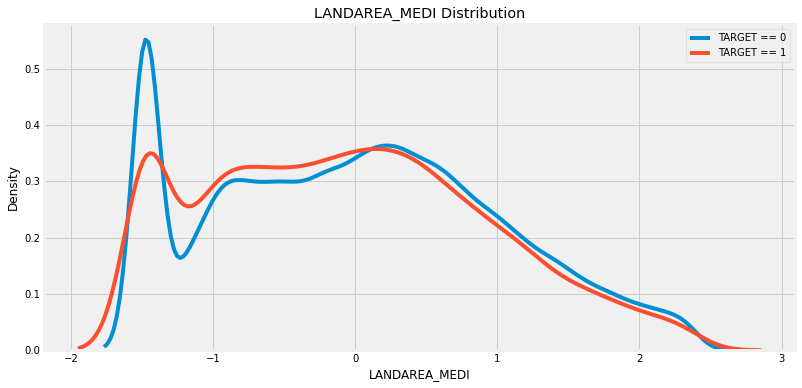

In [403]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LANDAREA_MEDI', app_train)

### LIVINGAPARTMENTS_MEDI

In [404]:
app_train['LIVINGAPARTMENTS_MEDI'].value_counts()

0.0513    4500
0.0684    4497
0.0770    2926
0.0599    2708
0.0855    2014
          ... 
0.2672       1
0.9149       1
0.8183       1
0.6020       1
0.3638       1
Name: LIVINGAPARTMENTS_MEDI, Length: 1097, dtype: int64

In [405]:
app_train[['LIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

LIVINGAPARTMENTS_MEDI    TARGET
LIVINGAPARTMENTS_MEDI               1.000000 -0.024621
TARGET                             -0.024621  1.000000

The correlation between LIVINGAPARTMENTS_MEDI and the TARGET is -0.0246
Median value for loan that was not repaid = 0.0684
Median value for loan that was repaid =     0.0770


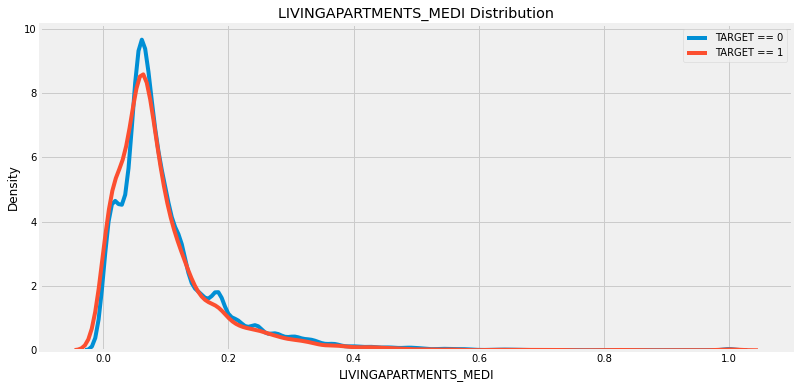

In [406]:
## 特徴量の分布
kde_target('LIVINGAPARTMENTS_MEDI', app_train)

In [407]:
## Yao-Johnson変換
num_cols = ['LIVINGAPARTMENTS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAPARTMENTS_MEDI'] = pt.transform(app_train[num_cols])
app_test['LIVINGAPARTMENTS_MEDI'] = pt.transform(app_test[num_cols])

In [408]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAPARTMENTS_MEDI']].corr()

TARGET  LIVINGAPARTMENTS_MEDI
TARGET                 1.000000              -0.031541
LIVINGAPARTMENTS_MEDI -0.031541               1.000000

The correlation between LIVINGAPARTMENTS_MEDI and the TARGET is -0.0315
Median value for loan that was not repaid = -0.2217
Median value for loan that was repaid =     -0.0586


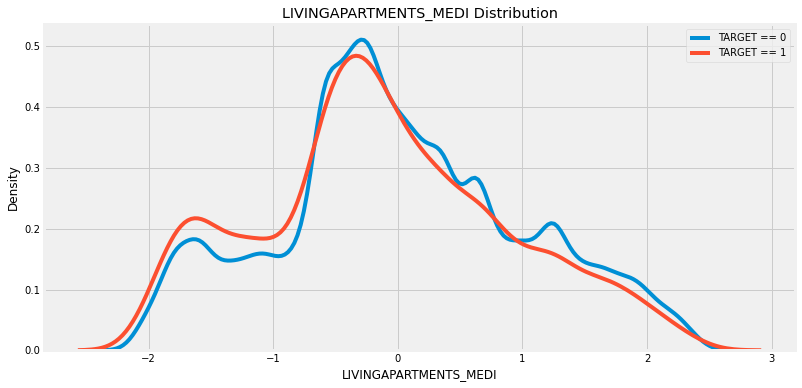

In [409]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAPARTMENTS_MEDI', app_train)

### LIVINGAREA_MEDI

In [410]:
app_train['LIVINGAREA_MEDI'].value_counts()

0.0000    299
0.0548    239
0.0518    234
0.0520    233
0.0521    232
         ... 
0.5532      1
0.4647      1
0.8707      1
0.4206      1
0.9445      1
Name: LIVINGAREA_MEDI, Length: 5281, dtype: int64

In [411]:
app_train[['LIVINGAREA_MEDI', 'TARGET']].corr()

LIVINGAREA_MEDI    TARGET
LIVINGAREA_MEDI         1.000000 -0.032739
TARGET                 -0.032739  1.000000

The correlation between LIVINGAREA_MEDI and the TARGET is -0.0327
Median value for loan that was not repaid = 0.0677
Median value for loan that was repaid =     0.0758


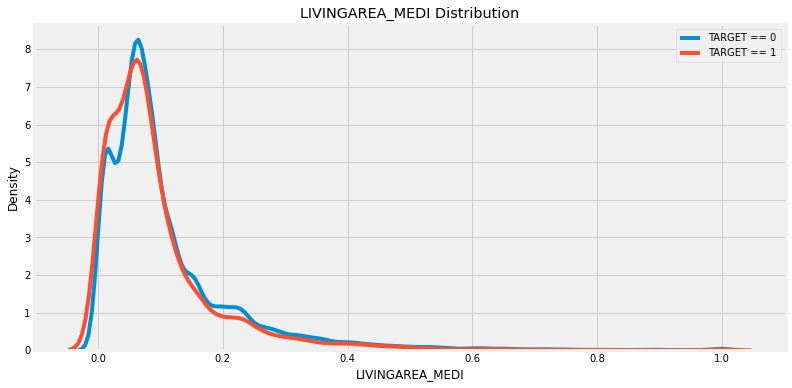

In [412]:
kde_target('LIVINGAREA_MEDI', app_train)

In [413]:
## Yao-Johnson変換
num_cols = ['LIVINGAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['LIVINGAREA_MEDI'] = pt.transform(app_train[num_cols])
app_test['LIVINGAREA_MEDI'] = pt.transform(app_test[num_cols])

In [414]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'LIVINGAREA_MEDI']].corr()

TARGET  LIVINGAREA_MEDI
TARGET           1.000000        -0.041492
LIVINGAREA_MEDI -0.041492         1.000000

The correlation between LIVINGAREA_MEDI and the TARGET is -0.0415
Median value for loan that was not repaid = -0.2190
Median value for loan that was repaid =     -0.0785


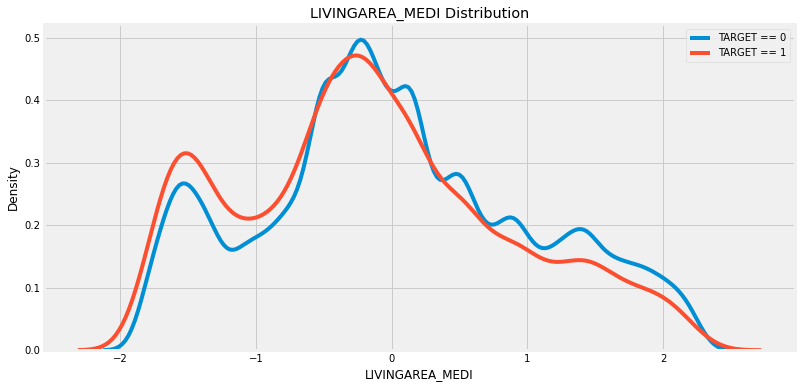

In [415]:
## Yao-Johnson変換後の特徴量の分布
kde_target('LIVINGAREA_MEDI', app_train)

### NONLIVINGAPARTMENTS_MEDI

In [416]:
app_train['NONLIVINGAPARTMENTS_MEDI'].value_counts()

0.0000    56097
0.0039    14126
0.0078     6493
0.0116     3788
0.0155     2557
          ...  
0.6638        1
0.6289        1
0.4852        1
0.3649        1
0.6056        1
Name: NONLIVINGAPARTMENTS_MEDI, Length: 214, dtype: int64

In [417]:
app_train[['NONLIVINGAPARTMENTS_MEDI', 'TARGET']].corr()

NONLIVINGAPARTMENTS_MEDI    TARGET
NONLIVINGAPARTMENTS_MEDI                  1.000000 -0.002757
TARGET                                   -0.002757  1.000000

In [418]:
## Yao-Johnson変換
num_cols = ['NONLIVINGAPARTMENTS_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['NONLIVINGAPARTMENTS_MEDI'] = pt.transform(app_train[num_cols])
app_test['NONLIVINGAPARTMENTS_MEDI'] = pt.transform(app_test[num_cols])

In [419]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'NONLIVINGAPARTMENTS_MEDI']].corr()

TARGET  NONLIVINGAPARTMENTS_MEDI
TARGET                    1.000000                 -0.006964
NONLIVINGAPARTMENTS_MEDI -0.006964                  1.000000

The correlation between NONLIVINGAPARTMENTS_MEDI and the TARGET is -0.0070
Median value for loan that was not repaid = -0.6927
Median value for loan that was repaid =     -0.6927


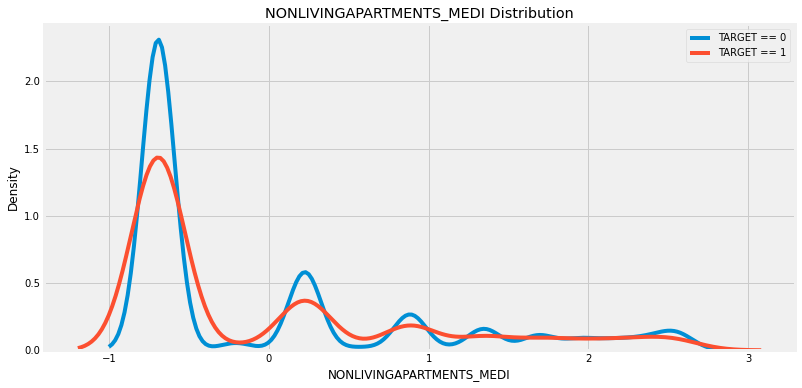

In [420]:
## Yao-Johnson変換後の特徴量の分布
kde_target('NONLIVINGAPARTMENTS_MEDI', app_train)

In [421]:
columns = ['NONLIVINGAPARTMENTS_MEDI']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### NONLIVINGAREA_MEDI

In [422]:
app_train['NONLIVINGAREA_MEDI'].value_counts()

0.0000    60954
0.0012      539
0.0022      478
0.0037      456
0.0044      431
          ...  
0.3908        1
0.2364        1
0.3819        1
0.3323        1
0.2940        1
Name: NONLIVINGAREA_MEDI, Length: 3323, dtype: int64

In [423]:
app_train[['NONLIVINGAREA_MEDI', 'TARGET']].corr()

NONLIVINGAREA_MEDI    TARGET
NONLIVINGAREA_MEDI            1.000000 -0.013337
TARGET                       -0.013337  1.000000

The correlation between NONLIVINGAREA_MEDI and the TARGET is -0.0133
Median value for loan that was not repaid = 0.0023
Median value for loan that was repaid =     0.0031


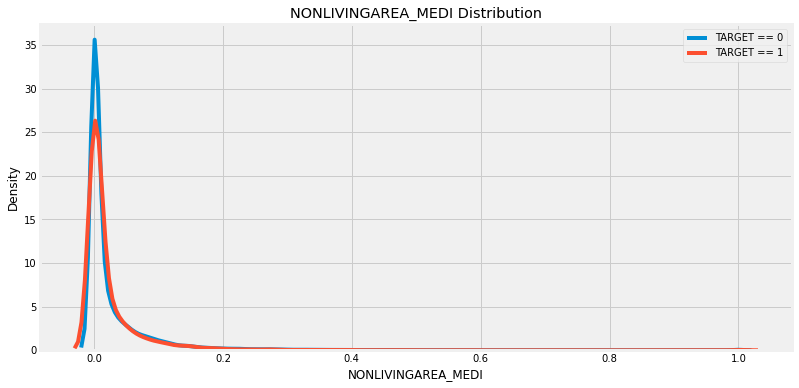

In [424]:
## 特徴量の分布
kde_target('NONLIVINGAREA_MEDI', app_train)

In [425]:
## Yao-Johnson変換
#num_cols = ['NONLIVINGAREA_MEDI']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['NONLIVINGAREA_MEDI'] = pt.transform(app_train[num_cols])
#app_test['NONLIVINGAREA_MEDI'] = pt.transform(app_test[num_cols])

In [426]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'NONLIVINGAREA_MEDI']].corr()

In [427]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('NONLIVINGAREA_MEDI', app_train)

### FONDKAPREMONT_MODE

In [428]:
app_train['FONDKAPREMONT_MODE'].value_counts()

reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [429]:
replace_columns = ['reg oper account', 'reg oper spec account', 'not specified', 'org spec account']
replace_value = [x for x in range(len(replace_columns))]
app_train['FONDKAPREMONT_MODE'].replace(replace_columns, replace_value, inplace=True)
app_test['FONDKAPREMONT_MODE'].replace(replace_columns, replace_value, inplace=True)
replace_value

[0, 1, 2, 3]

In [430]:
app_train['FONDKAPREMONT_MODE'].value_counts()

0.0    73830
1.0    12080
2.0     5687
3.0     5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [431]:
app_train[['FONDKAPREMONT_MODE', 'TARGET']].corr()

FONDKAPREMONT_MODE   TARGET
FONDKAPREMONT_MODE             1.00000 -0.00711
TARGET                        -0.00711  1.00000

In [432]:
columns = ['FONDKAPREMONT_MODE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### HOUSETYPE_MODE

In [433]:
replace_columns = app_train['HOUSETYPE_MODE'].unique().tolist()
replace_columns

['block of flats', nan, 'terraced house', 'specific housing']

In [434]:
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_columns

['block of flats', 'terraced house', 'specific housing']

In [435]:
replace_value = [x for x in range(len(replace_columns))]
replace_value

[0, 1, 2]

In [436]:
app_train['HOUSETYPE_MODE'].replace(replace_columns, replace_value, inplace=True)
app_test['HOUSETYPE_MODE'].replace(replace_columns, replace_value, inplace=True)

In [437]:
app_train['HOUSETYPE_MODE'].value_counts()

0.0    150503
2.0      1499
1.0      1212
Name: HOUSETYPE_MODE, dtype: int64

In [438]:
app_train[['HOUSETYPE_MODE', 'TARGET']].corr()

HOUSETYPE_MODE    TARGET
HOUSETYPE_MODE        1.000000  0.013429
TARGET                0.013429  1.000000

### TOTALAREA_MODE

In [439]:
app_train[['TOTALAREA_MODE', 'TARGET']].corr()

TOTALAREA_MODE    TARGET
TOTALAREA_MODE        1.000000 -0.032596
TARGET               -0.032596  1.000000

### WALLSMATERIAL_MODE

In [440]:
app_train['WALLSMATERIAL_MODE'].value_counts()

Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [441]:
replace_columns = app_train['WALLSMATERIAL_MODE'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['WALLSMATERIAL_MODE'].replace(replace_columns, replace_value, inplace=True)
app_test['WALLSMATERIAL_MODE'].replace(replace_columns, replace_value, inplace=True)

In [442]:
app_train['WALLSMATERIAL_MODE'].value_counts()

2.0    66040
0.0    64815
1.0     9253
4.0     5362
3.0     2296
6.0     1779
5.0     1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [443]:
app_train[['WALLSMATERIAL_MODE', 'TARGET']].corr()

WALLSMATERIAL_MODE   TARGET
WALLSMATERIAL_MODE             1.00000 -0.00699
TARGET                        -0.00699  1.00000

In [444]:
columns = ['WALLSMATERIAL_MODE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### EMERGENCYSTATE_MODE

In [445]:
app_train['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [446]:
replace_columns = app_train['EMERGENCYSTATE_MODE'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['EMERGENCYSTATE_MODE'].replace(replace_columns, replace_value, inplace=True)
app_test['EMERGENCYSTATE_MODE'].replace(replace_columns, replace_value, inplace=True)
app_train['EMERGENCYSTATE_MODE'].value_counts()

0.0    159428
1.0      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [447]:
app_train[['EMERGENCYSTATE_MODE', 'TARGET']].corr()

EMERGENCYSTATE_MODE    TARGET
EMERGENCYSTATE_MODE             1.000000  0.012201
TARGET                          0.012201  1.000000

### OBS_30_CNT_SOCIAL_CIRCLE

In [448]:
app_train['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      163910
1.0       48783
2.0       29808
3.0       20322
4.0       14143
5.0        9553
6.0        6453
7.0        4390
8.0        2967
9.0        2003
10.0       1376
11.0        852
12.0        652
13.0        411
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
25.0         11
24.0         11
27.0          5
26.0          3
30.0          2
28.0          1
29.0          1
47.0          1
348.0         1
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: int64

In [449]:
app_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_30_CNT_SOCIAL_CIRCLE    TARGET
OBS_30_CNT_SOCIAL_CIRCLE                  1.000000  0.009131
TARGET                                    0.009131  1.000000

The correlation between OBS_30_CNT_SOCIAL_CIRCLE and the TARGET is 0.0091
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


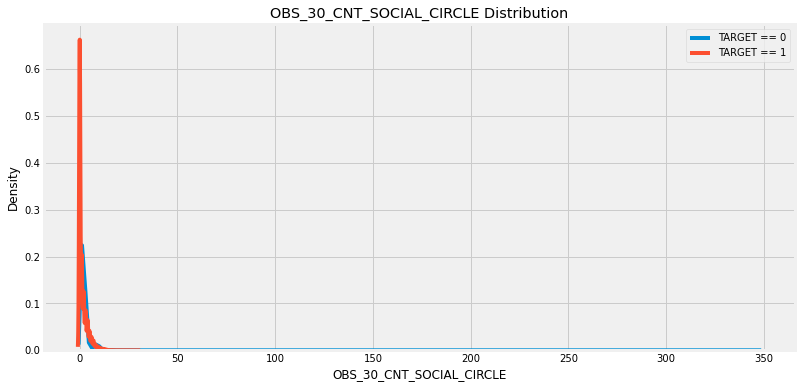

In [450]:
## 特徴量の分布
kde_target('OBS_30_CNT_SOCIAL_CIRCLE', app_train)

In [451]:
## Yao-Johnson変換
num_cols = ['OBS_30_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['OBS_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
app_test['OBS_30_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

In [452]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'OBS_30_CNT_SOCIAL_CIRCLE']].corr()

TARGET  OBS_30_CNT_SOCIAL_CIRCLE
TARGET                    1.000000                  0.009137
OBS_30_CNT_SOCIAL_CIRCLE  0.009137                  1.000000

The correlation between OBS_30_CNT_SOCIAL_CIRCLE and the TARGET is 0.0091
Median value for loan that was not repaid = -0.8919
Median value for loan that was repaid =     -0.8919


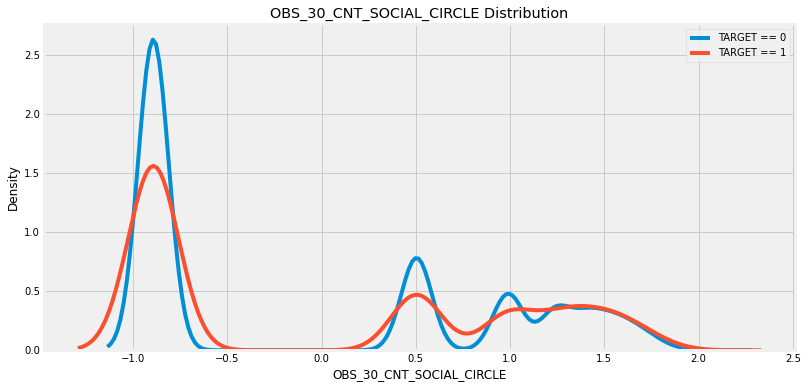

In [453]:
## Yao-Johnson変換後の特徴量の分布
kde_target('OBS_30_CNT_SOCIAL_CIRCLE', app_train)

In [454]:
columns = ['OBS_30_CNT_SOCIAL_CIRCLE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### DEF_30_CNT_SOCIAL_CIRCLE

In [455]:
app_train['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0     271324
1.0      28328
2.0       5323
3.0       1192
4.0        253
5.0         56
6.0         11
7.0          1
34.0         1
8.0          1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64

In [456]:
app_train[['DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_30_CNT_SOCIAL_CIRCLE    TARGET
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000  0.032248
TARGET                                    0.032248  1.000000

### OBS_60_CNT_SOCIAL_CIRCLE

In [457]:
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [458]:
app_train[['OBS_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

OBS_60_CNT_SOCIAL_CIRCLE    TARGET
OBS_60_CNT_SOCIAL_CIRCLE                  1.000000  0.009022
TARGET                                    0.009022  1.000000

The correlation between OBS_60_CNT_SOCIAL_CIRCLE and the TARGET is 0.0090
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


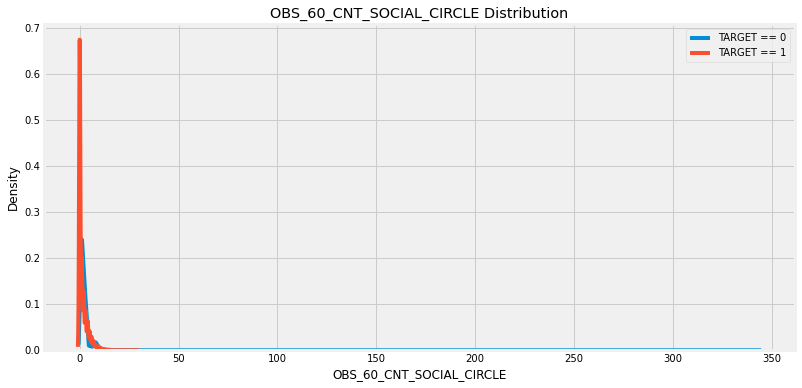

In [459]:
## 特徴量の分布
kde_target('OBS_60_CNT_SOCIAL_CIRCLE', app_train)

In [460]:
## Yao-Johnson変換
num_cols = ['OBS_60_CNT_SOCIAL_CIRCLE']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['OBS_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_train[num_cols])
app_test['OBS_60_CNT_SOCIAL_CIRCLE'] = pt.transform(app_test[num_cols])

In [461]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'OBS_60_CNT_SOCIAL_CIRCLE']].corr()

TARGET  OBS_60_CNT_SOCIAL_CIRCLE
TARGET                    1.000000                  0.008965
OBS_60_CNT_SOCIAL_CIRCLE  0.008965                  1.000000

The correlation between OBS_60_CNT_SOCIAL_CIRCLE and the TARGET is 0.0090
Median value for loan that was not repaid = -0.8884
Median value for loan that was repaid =     -0.8884


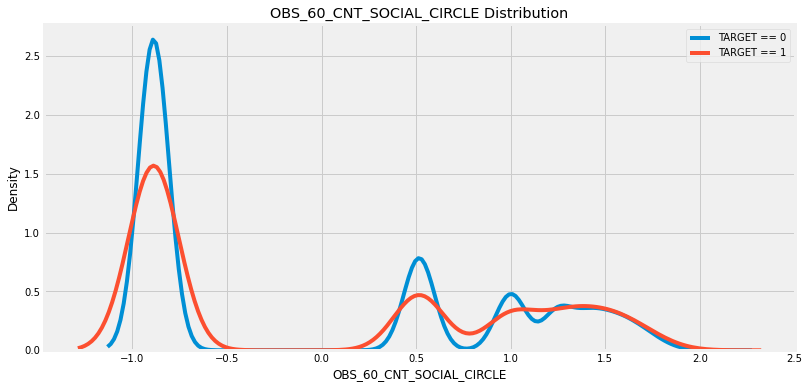

In [462]:
## Yao-Johnson変換後の特徴量の分布
kde_target('OBS_60_CNT_SOCIAL_CIRCLE', app_train)

In [463]:
columns = ['OBS_60_CNT_SOCIAL_CIRCLE']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### DEF_60_CNT_SOCIAL_CIRCLE

In [464]:
app_train['DEF_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0     280721
1.0      21841
2.0       3170
3.0        598
4.0        135
5.0         20
6.0          3
7.0          1
24.0         1
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [465]:
app_train[['DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']].corr()

DEF_60_CNT_SOCIAL_CIRCLE    TARGET
DEF_60_CNT_SOCIAL_CIRCLE                  1.000000  0.031276
TARGET                                    0.031276  1.000000

### DAYS_LAST_PHONE_CHANGE

In [466]:
app_train['DAYS_LAST_PHONE_CHANGE'].value_counts()

 0.0       37672
-1.0        2812
-2.0        2318
-3.0        1763
-4.0        1285
           ...  
-4051.0        1
-3593.0        1
-3622.0        1
-3570.0        1
-3538.0        1
Name: DAYS_LAST_PHONE_CHANGE, Length: 3773, dtype: int64

In [467]:
app_train[['DAYS_LAST_PHONE_CHANGE', 'TARGET']].corr()

DAYS_LAST_PHONE_CHANGE    TARGET
DAYS_LAST_PHONE_CHANGE                1.000000  0.055218
TARGET                                0.055218  1.000000

The correlation between DAYS_LAST_PHONE_CHANGE and the TARGET is 0.0552
Median value for loan that was not repaid = -594.0000
Median value for loan that was repaid =     -776.0000


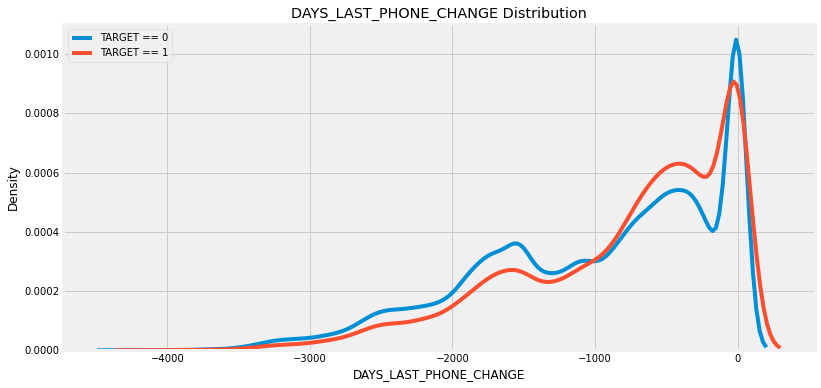

In [468]:
## 特徴量の分布
kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

In [469]:
## Yao-Johnson変換
#num_cols = ['DAYS_LAST_PHONE_CHANGE']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_train[num_cols])
#app_test['DAYS_LAST_PHONE_CHANGE'] = pt.transform(app_test[num_cols])

In [470]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']].corr()

In [471]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('DAYS_LAST_PHONE_CHANGE', app_train)

### FLAG_DOCUMENT_2

In [472]:
app_train['FLAG_DOCUMENT_2'].value_counts()

0    307498
1        13
Name: FLAG_DOCUMENT_2, dtype: int64

In [473]:
app_train[['FLAG_DOCUMENT_2', 'TARGET']].corr()

FLAG_DOCUMENT_2    TARGET
FLAG_DOCUMENT_2         1.000000  0.005417
TARGET                  0.005417  1.000000

In [474]:
columns = ['FLAG_DOCUMENT_2']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_3

In [475]:
app_train[['FLAG_DOCUMENT_3', 'TARGET']].corr()

FLAG_DOCUMENT_3    TARGET
FLAG_DOCUMENT_3         1.000000  0.044346
TARGET                  0.044346  1.000000

### FLAG_DOCUMENT_4

In [476]:
app_train[['FLAG_DOCUMENT_4', 'TARGET']].corr()

FLAG_DOCUMENT_4    TARGET
FLAG_DOCUMENT_4         1.000000 -0.002672
TARGET                 -0.002672  1.000000

In [477]:
columns = ['FLAG_DOCUMENT_4']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_5

In [478]:
app_train[['FLAG_DOCUMENT_5', 'TARGET']].corr()

FLAG_DOCUMENT_5    TARGET
FLAG_DOCUMENT_5         1.000000 -0.000316
TARGET                 -0.000316  1.000000

In [479]:
columns = ['FLAG_DOCUMENT_5']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_6

In [480]:
app_train[['FLAG_DOCUMENT_6', 'TARGET']].corr()

FLAG_DOCUMENT_6    TARGET
FLAG_DOCUMENT_6         1.000000 -0.028602
TARGET                 -0.028602  1.000000

### FLAG_DOCUMENT_7

In [481]:
app_train[['FLAG_DOCUMENT_7', 'TARGET']].corr()

FLAG_DOCUMENT_7   TARGET
FLAG_DOCUMENT_7          1.00000 -0.00152
TARGET                  -0.00152  1.00000

In [482]:
columns = ['FLAG_DOCUMENT_7']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_8

In [483]:
app_train[['FLAG_DOCUMENT_8', 'TARGET']].corr()

FLAG_DOCUMENT_8   TARGET
FLAG_DOCUMENT_8          1.00000 -0.00804
TARGET                  -0.00804  1.00000

In [484]:
columns = ['FLAG_DOCUMENT_8']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_9

In [485]:
app_train[['FLAG_DOCUMENT_9', 'TARGET']].corr()

FLAG_DOCUMENT_9    TARGET
FLAG_DOCUMENT_9         1.000000 -0.004352
TARGET                 -0.004352  1.000000

In [486]:
columns = ['FLAG_DOCUMENT_9']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_10

In [487]:
app_train[['FLAG_DOCUMENT_10', 'TARGET']].corr()

FLAG_DOCUMENT_10    TARGET
FLAG_DOCUMENT_10          1.000000 -0.001414
TARGET                   -0.001414  1.000000

In [488]:
columns = ['FLAG_DOCUMENT_10']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_11

In [489]:
app_train[['FLAG_DOCUMENT_11', 'TARGET']].corr()

FLAG_DOCUMENT_11    TARGET
FLAG_DOCUMENT_11          1.000000 -0.004229
TARGET                   -0.004229  1.000000

In [490]:
columns = ['FLAG_DOCUMENT_11']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_12

In [491]:
app_train[['FLAG_DOCUMENT_12', 'TARGET']].corr()

FLAG_DOCUMENT_12    TARGET
FLAG_DOCUMENT_12          1.000000 -0.000756
TARGET                   -0.000756  1.000000

In [492]:
columns = ['FLAG_DOCUMENT_12']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_13

In [493]:
app_train[['FLAG_DOCUMENT_13', 'TARGET']].corr()

FLAG_DOCUMENT_13    TARGET
FLAG_DOCUMENT_13          1.000000 -0.011583
TARGET                   -0.011583  1.000000

### FLAG_DOCUMENT_14

In [494]:
app_train[['FLAG_DOCUMENT_14', 'TARGET']].corr()

FLAG_DOCUMENT_14    TARGET
FLAG_DOCUMENT_14          1.000000 -0.009464
TARGET                   -0.009464  1.000000

In [495]:
columns = ['FLAG_DOCUMENT_14']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_15

In [496]:
app_train[['FLAG_DOCUMENT_15', 'TARGET']].corr()

FLAG_DOCUMENT_15    TARGET
FLAG_DOCUMENT_15          1.000000 -0.006536
TARGET                   -0.006536  1.000000

In [497]:
columns = ['FLAG_DOCUMENT_15']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_16

In [498]:
app_train[['FLAG_DOCUMENT_16', 'TARGET']].corr()

FLAG_DOCUMENT_16    TARGET
FLAG_DOCUMENT_16          1.000000 -0.011615
TARGET                   -0.011615  1.000000

### FLAG_DOCUMENT_17

In [499]:
app_train[['FLAG_DOCUMENT_17', 'TARGET']].corr()

FLAG_DOCUMENT_17    TARGET
FLAG_DOCUMENT_17          1.000000 -0.003378
TARGET                   -0.003378  1.000000

In [500]:
columns = ['FLAG_DOCUMENT_17']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_18

In [501]:
app_train[['FLAG_DOCUMENT_18', 'TARGET']].corr()

FLAG_DOCUMENT_18    TARGET
FLAG_DOCUMENT_18          1.000000 -0.007952
TARGET                   -0.007952  1.000000

In [502]:
columns = ['FLAG_DOCUMENT_18']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_19

In [503]:
app_train[['FLAG_DOCUMENT_19', 'TARGET']].corr()

FLAG_DOCUMENT_19    TARGET
FLAG_DOCUMENT_19          1.000000 -0.001358
TARGET                   -0.001358  1.000000

In [504]:
columns = ['FLAG_DOCUMENT_19']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_20

In [505]:
app_train[['FLAG_DOCUMENT_20', 'TARGET']].corr()

FLAG_DOCUMENT_20    TARGET
FLAG_DOCUMENT_20          1.000000  0.000215
TARGET                    0.000215  1.000000

In [506]:
columns = ['FLAG_DOCUMENT_20']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### FLAG_DOCUMENT_21

In [507]:
app_train[['FLAG_DOCUMENT_21', 'TARGET']].corr()

FLAG_DOCUMENT_21    TARGET
FLAG_DOCUMENT_21          1.000000  0.003709
TARGET                    0.003709  1.000000

In [508]:
columns = ['FLAG_DOCUMENT_21']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_HOUR

In [509]:
app_train['AMT_REQ_CREDIT_BUREAU_HOUR'].value_counts()

0.0    264366
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64

In [510]:
app_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_HOUR   TARGET
AMT_REQ_CREDIT_BUREAU_HOUR                     1.00000  0.00093
TARGET                                         0.00093  1.00000

In [511]:
columns = ['AMT_REQ_CREDIT_BUREAU_HOUR']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_DAY

In [512]:
app_train['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

In [513]:
app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_DAY    TARGET
AMT_REQ_CREDIT_BUREAU_DAY                   1.000000  0.002704
TARGET                                      0.002704  1.000000

In [514]:
columns = ['AMT_REQ_CREDIT_BUREAU_DAY']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_WEEK

In [515]:
app_train[['AMT_REQ_CREDIT_BUREAU_WEEK', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_WEEK    TARGET
AMT_REQ_CREDIT_BUREAU_WEEK                    1.000000  0.000788
TARGET                                        0.000788  1.000000

In [516]:
columns = ['AMT_REQ_CREDIT_BUREAU_WEEK']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_MON

In [517]:
app_train[['AMT_REQ_CREDIT_BUREAU_MON', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_MON    TARGET
AMT_REQ_CREDIT_BUREAU_MON                   1.000000 -0.012462
TARGET                                     -0.012462  1.000000

### AMT_REQ_CREDIT_BUREAU_QRT

In [518]:
app_train[['AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_QRT    TARGET
AMT_REQ_CREDIT_BUREAU_QRT                   1.000000 -0.002022
TARGET                                     -0.002022  1.000000

In [519]:
columns = ['AMT_REQ_CREDIT_BUREAU_QRT']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### AMT_REQ_CREDIT_BUREAU_YEAR

In [520]:
app_train[['AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']].corr()

AMT_REQ_CREDIT_BUREAU_YEAR   TARGET
AMT_REQ_CREDIT_BUREAU_YEAR                     1.00000  0.01993
TARGET                                         0.01993  1.00000

### applicationをEXPORT

In [521]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/app_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [522]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/app_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

### モデルを生成

In [523]:
#delete_columns = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR','NAME_TYPE_SUITE','OWN_CAR_AGE']
#app_train.drop(delete_columns, axis=1, inplace=True)

In [544]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')
#columns

In [525]:
app_test['NAME_CONTRACT_TYPE'].value_counts()
#app_test['CODE_GENDER'].value_counts()
#app_test['FLAG_OWN_CAR'].value_counts()
#app_test['FLAG_OWN_REALTY'].value_counts()
#app_test['CNT_CHILDREN'].value_counts()
#app_test['AMT_INCOME_TOTAL'].value_counts()
#app_test['AMT_CREDIT'].value_counts()
#app_test['AMT_ANNUITY'].value_counts()
#app_test['AMT_GOODS_PRICE'].value_counts()
#app_test['NAME_INCOME_TYPE'].value_counts()
#app_test['NAME_EDUCATION_TYPE'].value_counts()
#app_test['NAME_FAMILY_STATUS'].value_counts()
#app_test['NAME_HOUSING_TYPE'].value_counts()
#app_test['REGION_POPULATION_RELATIVE'].value_counts()
#app_test['DAYS_BIRTH'].value_counts()
#app_test['DAYS_EMPLOYED'].value_counts()
#app_test['OCCUPATION_TYPE'].value_counts()
#app_test['CNT_FAM_MEMBERS'].value_counts()
#app_test['REGION_RATING_CLIENT'].value_counts()
#app_test['REGION_RATING_CLIENT_W_CITY'].value_counts()
#app_test['EXT_SOURCE_1'].value_counts()
#app_test['EXT_SOURCE_2'].value_counts()
#app_test['EXT_SOURCE_3'].value_counts()
#app_test['credit_annuity_ratio'].value_counts()

0    48305
1      439
Name: NAME_CONTRACT_TYPE, dtype: int64

In [526]:
#num_cols = ['max_credit_day_overdue', 'max_days_credit_enddate', 'min_days_enddate_fact', 'max_amt_credit_max_overdue', 'cnt_credit_prolong_in_6month', 'sum_amt_credit_sum', 'sum_amt_credit_sum_debt', 'sum_amt_credit_sum_limit', 'sum_amt_credit_sum_overdue', 'avg_amt_annuity']

#data = pd.concat([app_train, app_test], sort=False)
#train = data[:len(app_train)]
#test = data[len(app_test):]


#y_train = train['TARGET']
#X_train = app_train.copy().drop('TARGET', axis=1)
#X_test = app_test.copy()

# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(X_train[num_cols])

# 変換後のデータで各列を置換
#X_train[num_cols] = pt.transform(X_train[num_cols])
#X_test[num_cols] = pt.transform(X_test[num_cols])

#X_train.head()

In [527]:
#y_preds = []
#models = []
#oof_train = np.zeros((len(X_train),))
#cv = KFold(n_splits=5, shuffle=True, random_state=0)

#categorical_features = columns

#params = {
#    'boosting_type': 'gbdt',  # default = 'gbdt'
#    'objective': 'binary',
#    'max_bin': 100,           #https://qiita.com/tanreinama/items/5e3eca5cf5e01169e5da
#    'learning_rate': 0.05,
#    'num_leaves': 80,
#    "early_stopping_round": 300,
#    'learning_rate': 0.01,    # default = 0.1
#    'feature_fraction': 0.8,  # default = 1.0
#    'bagging_freq': 1,        # default = 0
#    'bagging_fraction': 0.8,  # default = 1.0
#    'random_state': 0,        # default = None
#    #'device': 'gpu',
#    #'gpu_platform_id': 0,
#    #'gpu_device_id': 0,
#}

#for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
#    X_tr = X_train.loc[train_index, :]
#    X_val = X_train.loc[valid_index, :]
#    y_tr = y_train[train_index]
#    y_val = y_train[valid_index]
#    
#    lgb_train = lgb.Dataset(X_tr, y_tr,
#                                            categorical_feature=categorical_features)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
#                                            categorical_feature=categorical_features)
#
#    model = lgb.train(params, lgb_train,
#                                   valid_sets=[lgb_train, lgb_eval],
#                                   #verbose_eval=10,
#                                   num_boost_round=1000,
#                                 )
#
#    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
#    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#
#    y_preds.append(y_pred)
#    models.append(model)

In [528]:
# https://boomin.yokohama/archives/1482
# https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html

In [529]:
#num_cols = ['max_credit_day_overdue', 'max_days_credit_enddate', 'min_days_enddate_fact', 'max_amt_credit_max_overdue', 'cnt_credit_prolong_in_6month', 'sum_amt_credit_sum', 'sum_amt_credit_sum_debt', 'sum_amt_credit_sum_limit', 'sum_amt_credit_sum_overdue', 'avg_amt_annuity']

data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(X_train[num_cols])

# 変換後のデータで各列を置換
#X_train[num_cols] = pt.transform(X_train[num_cols])
#X_test[num_cols] = pt.transform(X_test[num_cols])

X_train.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100002                   0            1             0             0   
1      100003                   0            0             0             0   
2      100004                   1            1             1             0   
3      100006                   0            0             0             0   
4      100007                   0            1             0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0                 0  ...                 0                        0.0   
1                 3  ...                 0                        0.0   
2                 0  ...                 0                        0.0   
3                 0  ...                 0                        NaN   
4                 0  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 92 columns]

In [530]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[22:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72068	eval-auc:0.70603
[1]	train-auc:0.74318	eval-auc:0.72654
[2]	train-auc:0.75073	eval-auc:0.73160
[3]	train-auc:0.75334	eval-auc:0.73357
[4]	train-auc:0.75974	eval-auc:0.73756
[5]	train-auc:0.76247	eval-auc:0.73869
[6]	train-auc:0.76354	eval-auc:0.73976
[7]	train-auc:0.76628	eval-auc:0.74116
[8]	train-auc:0.76798	eval-auc:0.74218
[9]	train-auc:0.76902	eval-auc:0.74200
[10]	train-auc:0.77146	eval-auc:0.74377
[11]	train-auc:0.77251	eval-auc:0.74402
[12]	train-auc:0.77458	eval-auc:0.74432
[13]	train-auc:0.77560	eval-auc:0.74476
[14

[12]	train-auc:0.77481	eval-auc:0.73988
[13]	train-auc:0.77589	eval-auc:0.74010
[14]	train-auc:0.77699	eval-auc:0.74069
[15]	train-auc:0.77924	eval-auc:0.74148
[16]	train-auc:0.78105	eval-auc:0.74172
[17]	train-auc:0.78270	eval-auc:0.74220
[18]	train-auc:0.78391	eval-auc:0.74231
[19]	train-auc:0.78502	eval-auc:0.74239
[20]	train-auc:0.78634	eval-auc:0.74285
[21]	train-auc:0.78806	eval-auc:0.74387
[22]	train-auc:0.78955	eval-auc:0.74458
[23]	train-auc:0.79132	eval-auc:0.74511
[24]	train-auc:0.79298	eval-auc:0.74575
[25]	train-auc:0.79391	eval-auc:0.74633
[26]	train-auc:0.79503	eval-auc:0.74658
[27]	train-auc:0.79670	eval-auc:0.74693
[28]	train-auc:0.79802	eval-auc:0.74755
[29]	train-auc:0.79895	eval-auc:0.74789
[30]	train-auc:0.80011	eval-auc:0.74818
[31]	train-auc:0.80120	eval-auc:0.74875
[32]	train-auc:0.80253	eval-auc:0.74941
[33]	train-auc:0.80374	eval-auc:0.74973
[34]	train-auc:0.80507	eval-auc:0.75013
[35]	train-auc:0.80649	eval-auc:0.75061
[36]	train-auc:0.80770	eval-auc:0.75096


In [531]:
scores

[0.2429907245290214,
 0.2472537436232798,
 0.24769666139982852,
 0.24895823654464266,
 0.248499898131592]

In [532]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [533]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [534]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [535]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [536]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [537]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [538]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.078626       0.089093       0.059258       0.093861       0.080138
1       0.103868       0.096887       0.087847       0.140067       0.078187
2       0.025901       0.029351       0.024698       0.029444       0.038414
3       0.035712       0.036838       0.049427       0.041311       0.057437
4       0.144451       0.129717       0.116994       0.116468       0.148554

In [539]:
submit_all.corr()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  \
submit_all_00       1.000000       0.905505       0.910537       0.910507   
submit_all_01       0.905505       1.000000       0.901324       0.905109   
submit_all_02       0.910537       0.901324       1.000000       0.909694   
submit_all_03       0.910507       0.905109       0.909694       1.000000   
submit_all_04       0.913235       0.902797       0.909457       0.908774   

               submit_all_04  
submit_all_00       0.913235  
submit_all_01       0.902797  
submit_all_02       0.909457  
submit_all_03       0.908774  
submit_all_04       1.000000

In [540]:
submit_all = app_test[["SK_ID_CURR"]].copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.080195
1      100005  0.101371
2      100013  0.029562
3      100028  0.044145
4      100038  0.131237

In [541]:
len(submit_all)

48744

In [542]:
len(app_test)

48744

In [543]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/hcr_app_res_01.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.016039
1      100005  0.020274
2      100013  0.005912
3      100028  0.008829
4      100038  0.026247